# Sample Mass(Formula)-Difference Networks (MDiNs) Notebooks

- Sample_MDiNs_Yeast.ipynb
- Sample_MDiNs_Grapevine.ipynb
- Sample_Formula_Networks_Yeast.ipynb

# Sample Formula Networks of the Yeast Dataset

This notebook will cover the explorative studies into making networks from a list of formulas assigned to a metabolomics dataset - Formula-Difference Networks. Each Formula will represent a node. Nodes will be connected if the difference in their formulas can be associated to a simple chemical reaction (enzymatic or non-enzymatic) that led to a change in the elemental composition of its metabolite (formulas can be interconverted). For example, a methylation would correspond to adding a CH2 group to the formula.

The set of Formula differences are called a set of chemical groups or MDBs - Mass-Difference-based Building block - to adapt from the concept of Mass-Difference Networks.

### Organization of the networks  - Change this:

- Explanations of the chemical groups used to build the Formula Networks and extensions made to the concept.
- Reading files and treatment to obtain the dataset to build the network.
- Functions for building the networks and example of the construction of a Formula Network from a sample of the dataset.
- Extraction of some of their main characteristics and test of the analysis methods used later on with the sample Formula Networks.
- Building the sample Formula Networks and extracting the main results and characteristics of the networks.
- Building secondary datasets by applying the different network analysis (explanations of some of them) methods to the sample Formula Networks - each secondary dataset is identified by the network analysis methods that gave origin to it.
- Unsupervised Statistical Analysis (HCA and K-means clustering) of the secondary datasets.
- Supervised Statistical Analysis (Random Forest and PLS-DA), optimization, application and results.
- Permutation Tests (Supervised Analysis).
- Building a Formula Network with the features of the full yeast dataset.


### Needed imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import metabolinks as mtl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats
import multianalysis as ma
import metabolinks.transformations as transf
import netlsd as nl
import itertools

C:\Users\francisco\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# Formula Networks

## Chemical Transformations to Consider for building the network

One of the most critical questions of this endeavour is which chemical transformations, let's call them MDBs for simplicity to consider to represent the different possible simple biochemical reactions.  Ideally, they should cover most common and ubiquitous enzymatic and non-enzymatic reactions while also being a relatively small amount of reactions – a total of 15 were picked - while still maintaining the metabolite formula charge neutrality. For example, to maintain neutrality, a phosphorylation would mean the overall addition of a PO3H group – addition of a -(PO3)2- group + 2 H+ (maintaining neutrality) to replace an H atom in a metabolite. All the MDBs chosen represent changes in metabolites of no more than 5 atoms and less than 80 Da (small size). Each MDB should represent a set of chemically known reactions and a change in every main element in metabolites (C, H, O, N, S and P) is represented by at least one of the MDBs. To fulfil these conditions, representative MDBs were searched using BRENDA (https://www.brenda-enzymes.org/). The groups chosen were the following (check Table 2.2 of the dissertation for greater detail and mass):

- CH2 (methylation) EC 2.1.1
- O (oxygenation) EC1?
- H2 (Hydrogenation) EC1?
- O(-NH) (Aminase) (NH3(-O) - H2) EC3.5 EC6.3
- PO3H (phosphorylation) EC2.7 
- NH3(-O) (transaminases)  EC2.6.1
- SO3 (sulphation) EC2.8.2
- CO (things like formylation) EC2.1.2
- CO2 (carboxylation, decarboxylation) EC2.1.3 EC4 (CO+O) 
- CHOH (Hydroxymethylation) EC2.1.2 (CH2 + O)
- NCH (formidoyltransferase) EC2.1.2.4/5
- CONH (carbamoyltransferase) EC2.1.3 (NCH + O)
- C2H2O (acetylation) EC2.3 (CO+CH2)
- S EC2.8.1 somewhat rare but we need an extra S reaction
- H2O (condensations? cyclizations like in 3.5.2?) (H2 + O)


#### Other chemical transformations that could be used if one wanted to - some candidates

- CN2H2 Amidinotransferases  EC.2.1.4 (only 2 enzymes)
- Transketolases and transaldolases EC2.2
- Most acyltransferases EC2.3
- COCH2COO (malonyl) - too big? EC2.3
- EC2.4 Glycosyltransferases - too big
- EC2.5 alkyl and aryl groups bigger than methyl - dimethylalyl
- EC 2.6.3.1 Just one enzyme NH
- S2O2 not worth
- Nitrile Hydrolase (H202(-N))

### Extensions made

Since the overall idea mentioned was generating underconnected networks despite the 15 groups used (originally) to establish the network, an extension to the concept was applied to generate more connected networks that could be more reliably analysed.

The extension took into account the possibility of "missing links". That is, a metabolite in a chain of a certain transformation could be missing so we try to add multiple of said transformations to see if there are further elements in the chain. This was done until a maximum of 5 MDBs away. Of course, the more multiples of a group needed to connect to another formula, the weaker said connection is. This was represented by the attribute weight where a value of 1 was added to the weight for each extra multiple added.

For example, imagine the node C10H20O6. Testing a connection with the CH2 MDB, we try to find the node C11H22O6. If it doesn't exist, we can see if it's a missing link in the chain and search for the node further on in the chain with 2 more CH2 in relation to C10H20O6, that is, the node C12H2406, then C13H26O6, until a maximum of 5 more CH2 groups in relation to the original node. Imagine C12H24O6 doesn't exist, but the node C13H26O6 exists. So the node is connected to C10H20O6 but with the weight/distance of 3 instead of the normal 1, since the distance between the nodes is equal to 3 CH2s to take into account that this edge is less "direct" than others and should have a lesser importance.

## Yeast Dataset analysed

Yeast Dataset file - '5yeasts_notnorm.csv'

The Yeast dataset was acquired by J. Luz. The Yeast dataset consists of 15 samples of FT-ICR-MS metabolomics data obtained in positive ionization mode - 3 biological replicates of 5 different strains of _Saccharomyces cerevisiae_ : the reference strain BY4741 (represented as BY) and 4 single-gene deletion mutants of this strain – ΔGLO1, ΔGLO2, ΔGRE3 and ΔENO1 represented, respectively, as dGLO1, dGLO2, dGRE3 and dENO1. These deleted genes are directly or indirectly related to methylglyoxal metabolism.

Peak Alignment and Peak Filtering was performed with MetaboScape 4.0 software (see dissertation for details in sample preparation, pre-processing, formula assignment). In short, the peak filtering made was made by keeping all features that appeared in at least 2 samples of the full dataset.

Yeast Dataset was obtained with Electrospray Ionization in Positive Mode, Human leucine enkephalin (Sigma Aldrich) is the reference feature (internal standard) used ([M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da) and pre-processed by MetaboScape 4.0 (Bruker Daltonics) - see dissertation for details in pre-processing and formula assignment.

### Reading the File with the Yeast Dataset

Before anything else, we will have to read the files for the datasets we are going to use. The dataset that we will use will be the Yeast Dataset since this is the only dataset with Formulas assigned which this method requires (networks will be built by differences between Formulas).

Most of this is identical to BinSim_Analysis_YD_notnorm.ipynb notebook but since we don't want to split the metadata and the intensity data we keep all the data in the same dataset.

We will also have the grapevine dataset on standby if we want to experiment with it.

#### Function to read and treat the Yeast .csv file

In [2]:
def reading_MetScape_file(filename,
                          col_renamer=None,
                          add_labels=None,
                          remove_ref_feat=None,
                          prefix_to_drop=None):
    
    """Read in a MetaboScape bucket table from a CSV file."""
    
    data = pd.read_csv(filename).set_index('Bucket label')
    data = data.sort_values(by = 'm/z')
    
    # optionally rename sample_names
    if col_renamer is not None:
        data = data.rename(columns=renamer)
    
    # optionally remove columns with a given prefix. Eg. 'ENO'
    if prefix_to_drop is not None:
        cols2drop = [c for c in data.columns if c.startswith(prefix_to_drop)]
        data = data.drop(columns=cols2drop)
    
    # optionally remove a reference feature (if already normalized)
    if remove_ref_feat is not None:
        #print(f'Feature {remove_ref_feat}\n{data.loc[remove_ref_feat, :]}\n----------')
        data = data.drop(index=[remove_ref_feat])
    
    # split in peak metadata and intensities
    # peak_cols = ['m/z', 'Name', 'Formula']
    # intensity_cols = [c for c in list(data.columns) if c not in peak_cols]
    # peaks = data[peak_cols]
    # intensities = data[intensity_cols]

    # replace zeros for NaN's
    #intensities = intensities.replace(0, np.nan).dropna(how='all')
    
    # force peaks to have the same features as the (trimmed) intensities
    #peaks = peaks.reindex(intensities.index)

    # optionally, add labels to intensities
    if add_labels is not None:
        data = mtl.add_labels(data, labels=add_labels)
    
    return data

In [3]:
def renamer(colname):
    # Useful to optionally remove all those 00000 from sample names
    return ''.join(colname.split('00000'))

leu_enk_name = '555.2692975341 Da'

#labels = 'Metadata BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split() # if ENO is removed, change this
labels = 'BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split() # if ENO is removed, change this

In [4]:
# Read in the two files and keep results in dicts 
prefix_to_drop = None # change to 'ENO' to remove ENO strain

# Yeast Dataset used in the dissertation is under the filename '5yeasts_notnorm.csv'

yeast_data = reading_MetScape_file('5yeasts_notnorm.csv', 
                                       remove_ref_feat=None,
                                       add_labels=None, # Not add labels for now
                                       col_renamer=renamer,
                                       prefix_to_drop=None)
yeast_data

,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
Bucket label,,,,,,,,,,,,,,,,,,
200.1775759522 Da,201.18485,Butyl octanoate,C12H24O2,0.00,0.00,0.000,5.524132e+05,648388.25,6.080372e+05,6.375496e+05,610135.875,656653.625,6.310158e+05,6.798519e+05,5.984907e+05,9.431856e+05,8.160908e+05,8.172168e+05
200.2661522455 Da,201.27343,NaN,NaN,0.00,0.00,575903.125,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
200.2930225885 Da,201.30030,NaN,NaN,1238710.75,1275006.75,1283941.750,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,8.679426e+05,7.015142e+05,7.361217e+05
201.1727696159 Da,202.18005,NaN,C11H23NO2,3945019.75,3852594.00,3821208.250,4.204017e+06,4131124.25,4.059027e+06,4.352161e+06,4440771.000,4499343.500,4.345543e+06,4.091804e+06,4.545699e+06,4.248517e+06,4.207834e+06,4.208490e+06
201.1729328725 Da,202.18021,NaN,C11H23NO2,3404298.50,3366785.00,3348790.750,3.672346e+06,3737722.00,3.793184e+06,3.923927e+06,3804580.500,3801558.250,3.835366e+06,3.708862e+06,3.889770e+06,3.635306e+06,3.618243e+06,3.543283e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995.1450511879 Da,2996.15233,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,5.629427e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2995.8961895300 Da,2996.90347,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,5.415538e+05,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2996.7812722438 Da,2997.78855,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,5.776696e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


`feature_filter` function:

Used to join different features that share the same formula by adding all of the intensity in each sample for each of those features. The exact m/z that remains corresponds to the feature that contributes the most to the full intensity of the different features that share the formula.

MetaboScape makes different 'buckets' and quantifies them as the features of a dataset. Sometimes, the same peak can be split into multiple buckets (errors in the algorithm). Here, these mistakes that could be identified due to the same formula assignment are rectified. The new bucket of the joined features is the one that contributes most to the full intensity across the samples since it should correspond to the peak "center".

In [5]:
def feature_filter(Spectra):
    """Join all features that share the same formula by addition.
       
       Spectra: Pandas DataFrame (dataset).
       
       Returns: Pandas DataFrame with filtered dataset.
    """

    df = Spectra
    # Variables to store results
    rp = pd.DataFrame(columns = df.columns)
    rep = []
    # Series with number of times each formula appears in the dataset
    form_count = df['Formula'].value_counts()
    a = 0
    
    for i in df['Formula']:
        if pd.isnull(i) == True: # If no formula is assigned to the feature, the feature stays in the new dataset
            rp = rp.append(df.iloc[a,:])

        else: # If a formula is assigned
            if form_count[i] > 1: # If the formula appears more than one time in the dataset
                if i not in rep: # And If it didn't already appear before
                    
                    # Bucket label, name and formula info are the ones from the greater intensity m/z peak (of peaks with the
                    # same formula)
                    peaks = df.loc[df['Formula'] == i,:].iloc[:,3:].sum(axis = 1)
                    peaks_idx = peaks.idxmax()
                    info = df.loc[peaks_idx].iloc[:3] # Bucket label, name and formula info
                    
                    # Addition of all m/z peaks intensity with the same formula
                    newrow = df.loc[df['Formula'] == i,:].iloc[:,3:].sum(axis = 0)
                    newrow_c = pd.concat([info, newrow], axis = 0) # Join with the m/z peak metadata
                    # m/z peak is from the greater intensity m/z peak (of peaks with the same formula)
                    newrow_c = newrow_c.rename(df.loc[peaks_idx].name)
                    
                    # Append peak with intensity added from all peaks sharing the same formula
                    rp = rp.append(newrow_c)

                    rep.append(i) # Append repeating formulas so this process isn't repeated again for the other m/z peaks

            else:
                rp = rp.append(df.iloc[a,:]) # Append peaks with formulas that aren't repeated in the dataset
        a = a + 1

    # return DataFrame
    return rp

Obtained a treated dataset with only m/z peaks that have formulas assigned

In [6]:
# Drop m/z pekas that don't have Formulas assigned
yeast_df = yeast_data.dropna(subset = ['Formula'])

# Joining rows that have the same formula assigned (with feature_filter) while keeping rows without formulas assigned.
yeast_df = feature_filter(yeast_df)

# Only keep peaks below 1000 m/z - Very few peaks above 1000 m/z and mostrly uninformative in the sample MDiNs concept.
yeast_df = yeast_df[yeast_df.iloc[:,0] < 1000]

In [7]:
# Only keep features that appear in at least 2 samples - Minor peak filtering
yeast_df_temp = transf.keep_atleast(yeast_df.iloc[:,3:].replace({0:np.nan}), min_samples=2)
yeast_df = yeast_df.loc[yeast_df_temp.index]
yeast_df.loc[yeast_df_temp.index]

# Take out the 1 formula thatt has Cl in it - Not needed
#for i in yeast_df['Formula']:
#    if 'Cl' in i:
#        yeast_df = yeast_df.drop(yeast_df[yeast_df['Formula'] == i].index)

yeast_df # Final Dataset

,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
200.1775759522 Da,201.18485,Butyl octanoate,C12H24O2,0.000000e+00,0.000000e+00,0.000000e+00,5.524132e+05,6.483882e+05,6.080372e+05,6.375496e+05,6.101359e+05,656653.625,6.310158e+05,6.798519e+05,5.984907e+05,9.431856e+05,8.160908e+05,8.172168e+05
201.1727696159 Da,202.18005,NaN,C11H23NO2,7.349318e+06,7.219379e+06,7.169999e+06,7.876362e+06,7.868846e+06,7.852211e+06,8.276088e+06,8.245352e+06,8300901.750,8.180909e+06,7.800666e+06,8.435469e+06,7.883823e+06,7.826076e+06,7.751774e+06
201.9791043208 Da,202.98638,NaN,C4H10O3S3,5.979574e+05,0.000000e+00,5.714457e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
203.1156661180 Da,204.12294,L-Acetylcarnitine,C9H17NO4,9.080770e+06,8.507996e+06,8.790471e+06,1.306664e+07,1.276478e+07,1.262020e+07,4.052399e+06,4.071939e+06,3710997.750,5.500948e+06,5.500034e+06,5.690336e+06,5.576097e+06,5.274222e+06,5.336592e+06
203.1268992141 Da,204.13418,Glycyl-Lysine,C8H17N3O3,1.552573e+06,1.624512e+06,1.601379e+06,2.134372e+06,2.044589e+06,1.159726e+06,2.132446e+06,2.235339e+06,1278033.000,6.275618e+05,5.937806e+05,6.216861e+05,2.329378e+06,2.365200e+06,2.431183e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936.1311096856 Da,937.13839,NaN,C26H49O28PS3,3.029958e+06,2.973061e+06,2.738704e+06,2.281541e+06,2.485709e+06,2.563367e+06,2.585072e+06,2.869929e+06,2572778.500,2.244503e+06,2.645463e+06,2.345291e+06,2.530932e+06,2.422154e+06,2.315480e+06
938.1278533042 Da,939.13513,NaN,C27H38N16O10S6,6.270084e+05,0.000000e+00,8.009592e+05,0.000000e+00,5.759562e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.376864e+05,0.000000e+00
985.3207480406 Da,986.32802,NaN,C51H57NO15P2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.712075e+05,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.547402e+05,0.000000e+00
986.6853865669 Da,987.69266,NaN,C39H98N14O8S3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.051672e+05,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.263648e+05,0.000000e+00


#### Reading a sample from Grapevine dataset (in case of wanting to experiment)

File and formulas from the Formularity software (free formula assigning software) that was used to assign formulas to the features of a sample from the Grapevine Dataset - see FormGeneration_Assignment.ipynb for details

In [8]:
#CAN file with parameters: N+S+P Formula score, 1 ppm, 800 limit database
#Gv_CAN1 = pd.read_csv('Formularity_data/CAN_NSP_1_800.csv')
#Gv_CAN1[Gv_CAN1['El_comp'].notnull()]

### Functions to change how each formula is represented

On the dataset, each formula is represented as a string with the following structure: 'CxHxNxOxPxSx' where x is the number of each element. If x=1, it is absent; if x=0, the element itself won't appear in the formula.

The objective of the following function is to transform all formulas in the dataset into a dataframe where the number of atoms of each element in a formula will be represented in columns with the names 'C','H','O','N','S','P' (represent each element). The index will be the index of the original dataset.

The main function is called deformulator since we are de-constructing the formulas format.

In [9]:
def deformulator(df):
    """Transforms a set of formulas in string format into a DataFrame with columns corresponding to each element.
       Element order: Order of the elements in the formulas.
       
       df: Pandas DataFrame; dataset with a column named 'Formula' with the assigned formulas of each feature.
       
       returns: Pandas DataFrame; index is equal to the index of the dataset (not the formulas) and each columns is the count
    of each of the elements present in the formulas of the dataset.
    """
    
    filtered_formulas = df['Formula'].dropna() # Dropping empty cells (without formulas)
    
    formula = {} # Store
    
    for i in filtered_formulas:
        if 'C(13)' in i:
            # Ignores C(13) formulas - the C12 formulas already exist
            continue
        else:
            # Transform the string representing the formula into a dictionary and store all results in a dictionary
            formula[i] = formula_process(i)
            #formulas.loc[filtered_formulas[filtered_formulas == i].index[0]] = formula_process(i).iloc[0]
            
    # Transforming the dictionary of dictionaries into the pretended dataframe
    formula_df = pd.DataFrame.from_dict(formula).T
    formula_df = formula_df.replace({np.nan:0}) # Replace nan values when an element doesn't appear in a formula for 0
    
    return formula_df

Example:

    'String' format: 'C6H1206'
    
    'Dictionary' format: {'C':6, 'H':12, 'O':6}

In [10]:
def formula_process(formula):
    "Transforms a formula in string format into a dictionary."
    
    #results = pd.DataFrame(np.zeros((1,8)), columns = ['C','H','O','N','S','P','Cl','F'])
    # Empty dictionary to store the results
    results = {}
    count = ''
    letter = None
    
    # Run through the string
    for i in range(len(formula)):
        if formula[i].isupper(): # If i is an uppercase letter then it is an element
            if letter: # Just to account for the first letter in the formula where letter is None
                results[letter] = int(count or 1) # Reached another letter, store previous results and reset count
                count = ''
                
            if i+1 < len(formula): # In case it's a two letter element such as Cl
                if formula[i+1].islower(): # The second letter is always lower case
                    letter = formula[i] + formula[i+1] # Store new 2 letter element
                    continue
                    
            letter = formula[i] # Store new 1 letter element
            
        elif formula[i].isdigit():
            count = count + formula[i] # If number, add number to count
    
    # Store results of the last letter
    results[letter] = int(count or 1)
                    
    return results

## Example of Building a Network for a single sample

Sample chosen: Replicate nº 2 of the yeast strain BY

First, select the formulas that appear in that sample and use deformulator to get the needed dataframe.

In [11]:
BY2 = yeast_df[yeast_df.iloc[:,4] != 0] # Taking only formulas/rows that were present in the sample
formula_df = deformulator(BY2)
formula_df = formula_df[['C','H','O','N','S','P']] # Make the order of the elements better for us
formula_df.index = BY2['Formula'] # The string format formulas become the index

formula_df

,C,H,O,N,S,P
Formula,,,,,,
C11H23NO2,11.0,23.0,2.0,1.0,0.0,0.0
C9H17NO4,9.0,17.0,4.0,1.0,0.0,0.0
C8H17N3O3,8.0,17.0,3.0,3.0,0.0,0.0
C7H12N2O5,7.0,12.0,5.0,2.0,0.0,0.0
C6H10N2S3,6.0,10.0,0.0,2.0,3.0,0.0
...,...,...,...,...,...,...
C26H6N4O6S11,26.0,6.0,6.0,4.0,11.0,0.0
C37H81N5O8S4,37.0,81.0,8.0,5.0,4.0,0.0
C39H97N5O2S6,39.0,97.0,2.0,5.0,6.0,0.0


Now we have a dataframe where each column represents a chemical element which will be filled in each with the number of atoms of that element in the formula that represents the row.

Now, we will build a graph and establish connections between the formulas.

### Functions for Graph/Network building

Here we put the  functions we will need to build the different graphs, to add edges and edge attributes.

- edge_finder: searches for a specific edge between the selected node and all the other nodes for one of the simple chemical reactions.
- edge_assembler: performs all possible connections (with all the MDBs chosen) in the network by applying in succession edge_finder to each pair of node and chemical reaction (allows the presence of 'missing links' with the depth arg, depth = 1 - no 'missing link' allowed). 
- inverse_weight_attributer: gives and edge attribute to the graph that is the inverse of the weight of each edge to use with the weighted degree to give less important to connections "far away".

In [12]:
def edge_finder(G, df, node, c=0, h=0, o=0, n=0, s=0, p=0, depth=5, group=''):
    """Creates edges in a network between different formulas with specific elemental differences.
    
       G: networkX graph object; graph where edges will be added.
       df: Pandas DataFrame; dataframe with information about the formulas representing each node.
       node: Pandas Series/row of a DataFrame; specific node which will be connected with other similar nodes (row from the
    above DataFrame).
       c,h,o,n,s,p: integers; integers representing the difference each element (C,H,O,N,S,P respectively) should have between
    2 formulas to connect them with an edge.
       depth: int; number of possible 'missing links' between the 2 formulas accepted (weight of the node will be equal to the
    depth).
    """
    
    # See if there is a formula with the specified difference in relation to the chosen node
    choose = df[df['C'] == node['C'] + c]
    choose = choose[choose['H'] == node['H'] + h]
    choose = choose[choose['O'] == node['O'] + o]
    choose = choose[choose['N'] == node['N'] + n]
    choose = choose[choose['S'] == node['S'] + s]
    choose = choose[choose['P'] == node['P'] + p]
    
    if len(choose) > 0: # If a node was found
        G.add_edge(node.name,choose.index[0], weight = 1, group=group)
        #return 1 #The weight
    
    else:
        for j in range(2, depth+1):
            # See if there is a formula with j times the specified difference in relation to the chosen node
            # This is performed from 2 until the maximum depth given
            choose = df[df['C'] == node['C'] + j*c]
            choose = choose[choose['H'] == node['H'] + j*h]
            choose = choose[choose['O'] == node['O'] + j*o]
            choose = choose[choose['N'] == node['N'] + j*n]
            choose = choose[choose['S'] == node['S'] + j*s]
            choose = choose[choose['P'] == node['P'] + j*p]
            
            # End the function if a node is found
            if len(choose) > 0:
                G.add_edge(node.name,choose.index[0], weight = j, group=group)
                continue
                #return j #The weight
    
    #return 0 #No other node was found to connect the given node to

In [13]:
def edge_assembler(formula_df, G, depth=5):
    """Add all wanted possible edges to the formula network created and return a dictionary of the influence of each group
    in establishing the edges.
       
       G: networkX graph object; graph where edges will be added.
       formula_df: Pandas DataFrame; dataframe with information about the formulas representing each node.
       
       returns: dictionary with the importance of each group in building the network.
    """
    #groups = ['H2','CH2','CO2','O','CHOH','NCH','O(-NH)','OH','S','CONH','PO3H','NH3(-O)','SO3','CO', 'C2H2O', 'H2O']
    #group_influence = dict.fromkeys(groups,0)
    
    # For each possible node in the dataframe, try to find all connections to it
    for i in formula_df.index:
        #print(i)
        node = formula_df.loc[i]
        
        # H2
        edge_finder(G, formula_df, node, h=2, depth=depth, group='H2')
        
        # CH2
        edge_finder(G, formula_df, node, c=1, h=2, depth=depth, group='CH2')

        # CO2
        edge_finder(G, formula_df, node, c=1, o=2, depth=depth, group='CO2')

        # O
        edge_finder(G, formula_df, node, o=1, depth=depth, group='O')

        # CHOH
        edge_finder(G, formula_df, node, c=1, h=2, o=1, depth=depth, group='CHOH')

        # NCH
        edge_finder(G, formula_df, node, c=1, h=1, n=1, depth=depth, group='NCH')

        # O(-NH)
        edge_finder(G, formula_df, node, h=-1, o=1, n=-1, depth=depth, group='O(-NH)')

        # OH
        #edge_finder(G, formula_df, node, h=1, o=1, depth=depth, group='OH')

        # S
        edge_finder(G, formula_df, node, s=1, depth=depth, group='S')

        # CONH
        edge_finder(G, formula_df, node, c=1, h=1, o=1, n=1, depth=depth, group='CONH')
    
        # PO3(H)
        edge_finder(G, formula_df, node, h=1, o=3, p=1, depth=depth, group='PO3H')

        # NH3-O
        edge_finder(G, formula_df, node, h=3, o=-1, n=1, depth=depth, group='NH3(-O)')

        # SO3
        edge_finder(G, formula_df, node, h=0, o=3, s=1, depth=depth, group='SO3')

        # CO
        edge_finder(G, formula_df, node, c=1, o=1, depth=depth, group='CO')
            
        # C2H2O
        edge_finder(G, formula_df, node, c=2, h=2, o=1, depth=depth, group='C2H2O')
        
        # H2O
        edge_finder(G, formula_df, node, h=2, o=1, depth=depth, group='H2O')   

In [14]:
def inverse_weight_attributer (graph):
    """Adds an inverse weight attribute to the edges to do a specific degree count."""
    
    wei = {}
    for i in graph.edges.data('weight'):
        wei[(i[0], i[1])] = 1/i[2]
    nx.set_edge_attributes(graph, wei, 'weight_inv')

### Building the graph/network

First, we set up the graph Gr using the module NetworkX that will be mainly used from now on and add all the formulas as different nodes in the graph with the intensity information of each node (is not used further).

Then we use the edge_assembler function to establish all the edges in the network and add the inverse_weight_attributer to add the 'weight_inv' edge attribute with the inverse of the weigth of the edges which will be useful later.

In [15]:
Gr = nx.Graph()
Gr.add_nodes_from(formula_df.index) # Each formula is a node
nx.set_node_attributes(Gr,BY2.set_index(BY2['Formula'])['BY0_2'].to_dict(), name='Intensity') # Store intensity of each node

In [16]:
len(Gr.nodes())
#Gr.nodes()

610

In [17]:
BY2_groups = edge_assembler(formula_df,Gr) # Adding the edges
inverse_weight_attributer(Gr) # Adding the inverse weight attrbiute

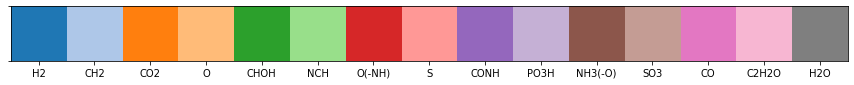

In [18]:
# Colours for each of the groups
colours = sns.color_palette('tab20', 15)

#unique_group = set(nx.get_edge_attributes(Gr,'group').values())
unique_group = ['H2','CH2','CO2','O','CHOH','NCH','O(-NH)','S','CONH','PO3H','NH3(-O)','SO3','CO', 'C2H2O', 'H2O']
group_colors = {lbl: c for lbl, c in zip(unique_group, colours)}

sns.palplot(group_colors.values())
new_ticks = plt.xticks(range(len(unique_group)), unique_group)

edge_colors =  [group_colors[lbl] for lbl in nx.get_edge_attributes(Gr,'group').values()]

C:\Users\francisco\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\francisco\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\Users\francisco\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


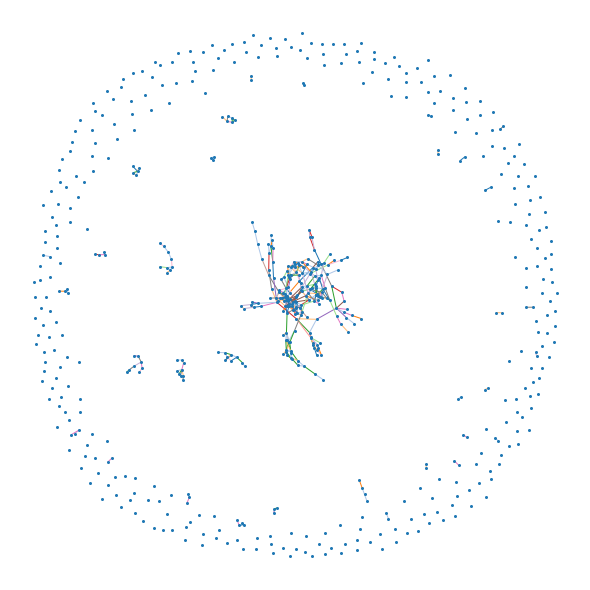

In [19]:
# Drawing the graph
# Colouring edges based on the groups used to establish them
plt.figure(figsize=(8,8))
nx.draw(Gr, node_size=4, width = 1, edge_color=edge_colors)#, with_labels=True)
plt.show()

#### Small Characterization of the network

In [20]:
# Main components of the network built
[len(c) for c in sorted(nx.connected_components(Gr), key=len, reverse=True)][:20]

[138, 47, 9, 9, 9, 8, 6, 5, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2]

In [21]:
# Diameter and Radius of the Network
Main_component = Gr.subgraph(list(sorted(nx.connected_components(Gr), key=len, reverse=True)[0]))
print('Diameter of the network:', nx.diameter(Main_component))
print('Radius of the network:', nx.radius(Main_component))

Diameter of the network: 15
Radius of the network: 8


In [22]:
isolated = 0
for i in Gr.degree():
    if i[1] == 0:
        isolated = isolated + 1

print('Nº of nodes without connections:', isolated)

Nº of nodes without connections: 314


#### Yeast Dataset Network Analysis

6 methods were applied (explanations after when applied to all networks)

- 3 centrality measures (Degree, Betweenness centrality, Closeness centrality)
- MDB Influence
- NetLSD (Network Laplacian Spectral Descriptor)
- GCD-11

3 measures of centrality were used to analyze the networks: degree, centrality_closeness, betweenness_centrality. The last two use the weights of the different edges and degree uses the inverse of the weight as given by the function inverse_weight_attributer, that is, if an edge has a weight/distance of x, it's contribution to the degree of each node will be 1/x.

In [23]:
# Degree
G_degree = dict(Gr.degree(weight='weight_inv'))
G_degree_all = sorted(G_degree.items(), key=lambda kv: kv[1], reverse = True)
G_degree_all[:10]

[('C18H34O3', 10.75),
 ('C16H30O3', 8.533333333333333),
 ('C16H30O2', 8.5),
 ('C18H34O4', 8.333333333333332),
 ('C23H45NO4', 7.833333333333333),
 ('C17H34O2', 7.5),
 ('C16H32O2', 7.0),
 ('C19H36O3', 6.833333333333333),
 ('C18H34O2', 6.5),
 ('C22H43NO3', 6.5)]

In [24]:
# Betweenness Centrality
G_betw = nx.betweenness_centrality(Gr, weight = 'weight')
G_betw_all = sorted(G_betw.items(), key=lambda kv: kv[1], reverse = True)
G_betw_all[:10]

[('C18H37NO3', 0.011039283587904283),
 ('C21H42O4', 0.010878049255273931),
 ('C22H43NO4', 0.010249158170974701),
 ('C21H44O5', 0.009324952592466726),
 ('C22H46O6', 0.00896797473712082),
 ('C18H34O4', 0.008709699109371164),
 ('C20H41NO3', 0.006415159006193538),
 ('C23H48O6', 0.006063582225882224),
 ('C23H45NO4', 0.006048620714365264),
 ('C18H38NO6P', 0.005826276246509182)]

In [25]:
# Closeness Centrality
G_closeness = nx.closeness_centrality(Gr, distance = 'weight')
G_closeness_all = sorted(G_closeness.items(), key=lambda kv: kv[1], reverse = True)
G_closeness_all[:10]

[('C18H37NO3', 0.039715690755505906),
 ('C18H34O4', 0.03961359386410357),
 ('C18H34O3', 0.038284939163071526),
 ('C19H36O4', 0.03814279211172349),
 ('C20H41NO3', 0.03786164130991718),
 ('C18H32O3', 0.03763049575857457),
 ('C17H34O2', 0.03749315818281335),
 ('C19H36O3', 0.03735681942578494),
 ('C22H43NO4', 0.03735681942578494),
 ('C18H37NO2', 0.03731159325214598)]

#### Group Influence calculation

Influence of each chemical group (representing types of chemical reactions) in establishing the edges in said network (slow) by counting the number of times each were responsible by establishing and edge (that contribution is represented by the 'weight_inv' attribute (inverse of the weight of the edge) to give more relevance to "direct" connections.

In [26]:
# Group Influence in building the network, equivalent to MDB Influence in Sample_MDiNs
BY2_groups = dict.fromkeys(unique_group, 0)
for i in Gr.edges():
    BY2_groups[Gr.edges()[i]['group']] = BY2_groups[Gr.edges()[i]['group']] + Gr.edges()[i]['weight_inv']
BY2_groups

{'H2': 39.233333333333334,
 'CH2': 89.21666666666665,
 'CO2': 17.0,
 'O': 46.10000000000001,
 'CHOH': 36.49999999999999,
 'NCH': 12.2,
 'O(-NH)': 9.0,
 'S': 3.0,
 'CONH': 6.75,
 'PO3H': 16.0,
 'NH3(-O)': 9.333333333333332,
 'SO3': 3.0,
 'CO': 25.666666666666668,
 'C2H2O': 19.333333333333332,
 'H2O': 31.033333333333335}

#### Sum of all influences

In [27]:
a = 0
for i in BY2_groups.values():
    a = a + i
a

363.3666666666667

#### NetLSD - Heat Analysis

See the diffusion of heat according to the package netlsd (nl) and plot the graph.

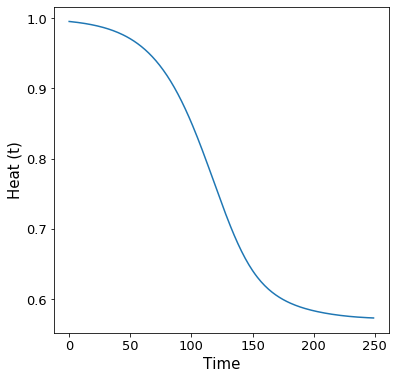

In [28]:
# 'Heat' Diffusion of the network
G_heat = nl.heat(Gr)

f, ax = plt.subplots(figsize=(6,6))
plt.plot(G_heat)    
        
plt.xlabel('Time', fontsize=15)
plt.ylabel('Heat (t)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

#### GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4-node graphlets) (see explanation after) 

In [29]:
def calculating_orbits(GG):
    """Calculates the number of times each node of the network is in each possible (non-redundant) orbit in graphlets (maximum
    4 nodes).
    
    Function is not very efficient, all nodes are passed, every graphlet is 'made' for each node present in it so it is made
    multiple times.
    
       GG: networkx graph;
    
       returns: dict; dictionary (keys are the nodes) of dictionaries (keys are the orbits and values are the number of times)
    """
    
    node_orbits = {} # To store results

    for i in GG.nodes():

        node_orbits[i] = {} # To store results
        orbits = node_orbits[i]

        ## size of comp
        # comp = len(nx.node_connected_component(GG, 'c'))

        # 2 node graphlets - orbit 0
        orbits['0'] = GG.degree(i)

        # 3 node graphlets - orbit 1,2 (and 3 redundant)
        node_neigh = list(GG.neighbors(i))

        # orbit 1 and 4 and 6 and 8 and 9
        n_orb = 0
        n_orb4 = 0
        n_orb6 = 0
        n_orb8 = 0
        n_orb9 = 0

        # orbit 1
        for j in node_neigh:
            neigh_neigh = list(GG.neighbors(j)) # Neighbours of the neighbour j of i
            neigh_neigh.remove(i) # Remove i since i is a neighbour of j
            for common in nx.common_neighbors(GG, i, j):
                neigh_neigh.remove(common) # Remove common neighbours of i and j
            n_orb = n_orb + len(neigh_neigh)


            # orbit 4 and 8
            for n3 in neigh_neigh:
                neigh_neigh_neigh = list(GG.neighbors(n3)) # Neighbours of the neighbour n3 of the neighbour j of i
                #neigh_neigh_neigh.remove(j)
                #if i in neigh_neigh_neigh:
                    #neigh_neigh_neigh.remove(i)     
                for common in nx.common_neighbors(GG, j, n3):
                    if common in neigh_neigh_neigh:
                        neigh_neigh_neigh.remove(common)

                for common in nx.common_neighbors(GG, i, n3):
                    if common in neigh_neigh_neigh:
                        neigh_neigh_neigh.remove(common)
                        # orbit 8
                        if common != j:
                            #print(i,j,n3,common)
                            n_orb8 = n_orb8 + 1/2 # always goes in 2 directions so it will always pass like this

                n_orb4 = n_orb4 + len(neigh_neigh_neigh)
                # print(neigh_neigh_neigh)

            # orbit 6 and 9
            for u,v in itertools.combinations(neigh_neigh, 2):
                if not GG.has_edge(u,v):
                    n_orb6 = n_orb6 + 1
                else:
                    n_orb9 = n_orb9 + 1         

        orbits['1'] = n_orb

        # orbit 2 and 5
        n_orb = 0
        n_orb5 = 0
        for u,v in itertools.combinations(node_neigh, 2):
            if not GG.has_edge(u,v):
                n_orb = n_orb + 1

                # orbit 5
                neigh_u = list(GG.neighbors(u))
                neigh_u.remove(i)
                for common in nx.common_neighbors(GG, i, u):
                    neigh_u.remove(common)

                neigh_v = list(GG.neighbors(v))
                neigh_v.remove(i)
                for common in nx.common_neighbors(GG, i, v):
                    neigh_v.remove(common)

                for common in nx.common_neighbors(GG, v, u):
                    if common in neigh_u:
                        neigh_u.remove(common)
                    if common in neigh_v:
                        neigh_v.remove(common) 

                n_orb5 = n_orb5 + len(neigh_u)
                n_orb5 = n_orb5 + len(neigh_v)

        orbits['2'] = n_orb

        # 4 node graphlets - orbit 4,5,6,7,8,9,10,11 (and 12,13,14 redundant)

        # orbit 4
        orbits['4'] = n_orb4

        # orbit 5
        orbits['5'] = n_orb5

        # orbit 6
        orbits['6'] = n_orb6

        # orbit 7 and 11
        n_orb = 0
        n_orb11 = 0
        for u,v,j in itertools.combinations(node_neigh, 3):
            n_edge = [GG.has_edge(a,b) for a,b in itertools.combinations((u,v,j), 2)]
            #print(sum(n_edge))
            if sum(n_edge) == 0:
                n_orb = n_orb + 1
            elif sum(n_edge) == 1:
                n_orb11 = n_orb11 + 1

        orbits['7'] = n_orb

        # orbit 8
        orbits['8'] = int(n_orb8)

        # orbit 9
        orbits['9'] = n_orb9

        # orbit10
        n_orb = 0
        for j in node_neigh:
            neigh_neigh = list(GG.neighbors(j))
            neigh_neigh.remove(i)
            for u,v in itertools.combinations(neigh_neigh, 2):
                if sum((GG.has_edge(i,u), GG.has_edge(i,v))) == 1:
                    if not GG.has_edge(u,v):
                        n_orb = n_orb + 1

        orbits['10'] = n_orb

        # orbit 11
        orbits['11'] = n_orb11
    
    return node_orbits

In [30]:
# Counting the number of the number of times each node has each of the 11 orbits, make it a DataFrame
G_GCD = calculating_orbits(Gr)
G_GCD_df = pd.DataFrame.from_dict(G_GCD).T

# Graphlet Correlation Matrix (Spearman correlation between the different columns - orbits)
CorrMat = stats.spearmanr(G_GCD_df,axis=0)[0]

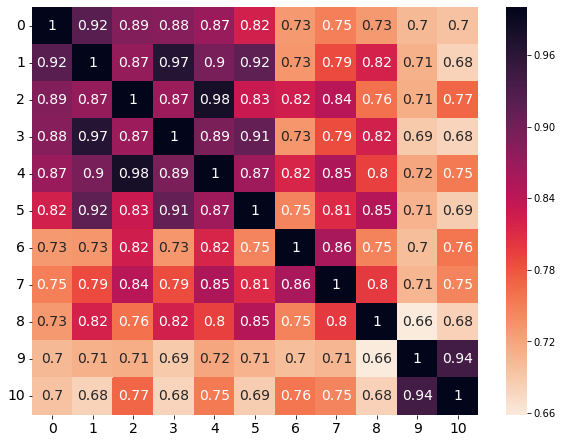

In [31]:
# Representing the Graphlet Correlation Matrix
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

# Formula Network Analysis

## Building the Formula Network for each sample and storing main results from each network

edge_assembler function is slow

Here the Formula Networks will be analysed by different metrics and a "secondary" dataset will be built for each different network analysis methods with features related to the method used.

In [32]:
# Making all the graphs and storing
G = {}

# Storage for the centrality measures results
G_degree = {} 
G_betw = {}
G_closeness = {}
#G_degree_20 = {}
#G_betw_20 = {}
#G_closeness_20 = {}

# Storage for the information on group influence (explained after), size of components formed and heat diffusion of the
# different graphs according to netlsd
G_groups = {}
G_components = {}
G_heat = {}

for j in yeast_df.columns[3:]:
    df = yeast_df[yeast_df.loc[:,j] != 0] #Selecting the formulas that actually appear in each sample
    formula_df = deformulator(df) #Transforming into the pretended DataFrame
    formula_df.index = df['Formula'] #Using the 'string' formulas as indexes
    
    #Making the graphs
    G[j] = nx.Graph()
    G[j].add_nodes_from(formula_df.index)
    nx.set_node_attributes(G[j],df.set_index(df['Formula'])[j].to_dict(), name='Intensity') #Store intensity of each node
    edge_assembler(formula_df, G[j])
    inverse_weight_attributer(G[j]) #Adding the edge attribute "weight_inv"
    
    print(j, 'is done')

BY0_1 is done
BY0_2 is done
BY0_3 is done
GRE3_1 is done
GRE3_2 is done
GRE3_3 is done
ENO1_1 is done
ENO1_2 is done
ENO1_3 is done
dGLO1_1 is done
dGLO1_2 is done
dGLO1_3 is done
GLO2_1 is done
GLO2_2 is done
GLO2_3 is done


In [33]:
# Storing the main centrality measures, size of the different components, group influence and heat diffusions
for j in G:
    G_degree[j] = dict(G[j].degree(weight='weight_inv'))
    #G_degree_20[j] = sorted(G_degree[j], key=G_degree[j].get, reverse = True)[:20] # Taking the top 20 in each graph/sample
    
    G_betw[j] = nx.betweenness_centrality(G[j], weight = 'weight')
    #G_betw_20[j] = sorted(G_betw[j], key=G_betw[j].get, reverse = True)[:20] # Taking the top 20 in each graph/sample
    
    G_closeness[j] = nx.closeness_centrality(G[j], distance = 'weight')
    #G_closeness_20[j] = sorted(G_closeness[j], key=G_closeness[j].get, reverse = True)[:20] # Taking the top 20
    
    # Group_influence
    G_groups[j] = dict.fromkeys(unique_group, 0)
    for i in G[j].edges():
        G_groups[j][G[j].edges()[i]['group']] = G_groups[j][G[j].edges()[i]['group']] + G[j].edges()[i]['weight_inv']
    
    # Only get the components > 1 (more than just an isolated node)
    G_components[j] = [len(c) for c in sorted(nx.connected_components(G[j]), key=len, reverse=True) if len(c) > 1]
    
    G_heat[j] = nl.heat(G[j])

### 3 Centrality measures, Group Influence, Heat Diffusion and GCD-11 analysis

The 3 first network analysis methods focus on the characteristics of each node and each node is kept as a feature of a new dataset while the last 3 methods focus on the overall topology and structure of the network reducing drastically the number of features. By analysing in both manners, we obtained a more complete analysis of the networks and can be more confident in our results. 

### Obtaining the dataframes for analysis

#### Centrality measures dataframes

The analysis of each centrality measure is completely independent of each other.

2 different ways were used to analyse the centrality measures: 1) Top 20 (X) (In disuse) and 2) Using the centrality measures values of all nodes in all networks.

#### Top20 (X) - NOT used anymore if you want to be used take out the comments (#) of lines with '20' in the two cell aboves and take out alll needed comments (#) in the two cells below - don't run the cell below those two.

Here, a binary dataframe is made where the formulas that appear in at least the top 20 features in one of the samples are the considered features (individual dataframes are made for each centrality measure). A sample has a value of 1 in a said feature if said feature is in it's top 20 formula with the highest value in the centrality measure that is being used for analysis and 0 if it isn't present.

After that, normal binary similarity analysis is made as it was done in the similarity_analysis notebooks. Hierarchical Clustering (dendrograms), Random Forest and PLS-DA models to make predictive models and PLS-DA representation on the 2 main components is performed. 

In [34]:
# Making the dataframe for similarity comparisons
#union_degree = ()
#union_betw = ()
#union_closeness = ()
#for i in G_degree_20:
    # All formulas that appear in at least one top 20 (for each category)
#    union_degree = set(union_degree).union(G_degree_20[i])
#    union_betw = set(union_betw).union(G_betw_20[i])
#    union_closeness = set(union_closeness).union(G_closeness_20[i])
    
#degree_df = pd.DataFrame(0, index = union_degree, columns = G_degree_20.keys())
#betw_df = pd.DataFrame(0, index = union_betw, columns = G_betw_20.keys())
#closeness_df = pd.DataFrame(0, index = union_closeness, columns = G_closeness_20.keys())

In [35]:
# Filling the Dataframe
#for i in G_degree_20:
#    for j in G_degree_20[i]:
#        degree_df.loc[j,i] = 1

#for i in G_betw_20:
#    for j in G_betw_20[i]:
#        betw_df.loc[j,i] = 1

#for i in G_closeness_20:
#    for j in G_closeness_20[i]:
#        closeness_df.loc[j,i] = 1

#### All features - not simplified to Top X - Don't run next cell if you want to do Top X

Top X has slightly worse performances (with less 100%) and also makes group influence be close to degree which doesn't happen here since degree gets a better performance like this.

In [36]:
degree_df = pd.DataFrame.from_dict(G_degree).replace({np.nan:0})
betw_df = pd.DataFrame.from_dict(G_betw).replace({np.nan:0.0})
closeness_df = pd.DataFrame.from_dict(G_closeness).replace({np.nan:0.0})

#### Group Influence Dataframes or MDB Influence Dataframes

Transform the dictionary of dictionaries with the Group Influence stats into a dataframe. Now, it can be analysed together with the binary dataframes made above. The analysis performed will be the same than for the rest of dataframes, however, for this dataframe the distance measure used in hierarchical clustering is euclidean and not a binary measure such as the jaccard distance since this dataframe is not binary.

#### What is "Group Influence" in this context?

Each MDB that represents a set of chemical reactions has a value attached in every network built. This number corresponds to the amount of edges that were established between two formulas that used this Group, that is, the amount of times one of the set of chemical reactions can transform a formula into another (a metabolite into another). This was done in a similar way to the calculation of the degree for each individual node. Thus, each direct reaction with no "missing links" (edge weight = 1) adds one to the value of that group in the network and the "farther away" the two formulas are, a lower value will be added - 1/weight(edge).

This value then should represent the importance of the Group in establishing the network when compared to the rest of the groups. The bigger the value, the higher the impact of that Group in establishing the network. To normalize the comparison between sample MDiNs with a lot and few edges, the Groups values are normalized by the total number of edges established in the network (and multiplied by 100). Then, they represent the % of edges each Group helped establish.

Here we test if the importance of these Groups in establishing the overall network is characteristic of the strain of the sample.

We also can see the overall influence of each Group in building the networks. 

In [37]:
groups_df = pd.DataFrame.from_dict(G_groups)
groups_df

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
H2,34.533333,39.233333,39.400000,42.866667,53.783333,55.066667,23.750000,34.700000,35.866667,42.566667,41.400000,44.233333,32.866667,31.233333,32.066667
CH2,78.200000,89.216667,90.383333,83.850000,96.850000,100.433333,51.133333,65.300000,67.300000,74.183333,77.050000,80.850000,69.650000,77.983333,87.766667
CO2,15.333333,17.000000,18.333333,20.333333,18.500000,22.833333,17.000000,19.000000,16.000000,17.500000,17.000000,17.000000,16.000000,19.000000,19.333333
O,38.850000,46.100000,46.216667,46.183333,50.266667,56.666667,24.266667,39.383333,37.433333,47.966667,47.216667,48.666667,38.300000,38.966667,43.333333
CHOH,33.500000,36.500000,35.666667,33.000000,39.666667,47.500000,16.333333,20.166667,23.833333,34.500000,33.166667,32.166667,23.666667,24.333333,25.666667
NCH,10.200000,12.200000,10.200000,7.333333,8.333333,7.333333,4.000000,8.333333,8.333333,7.333333,9.333333,8.333333,5.000000,4.000000,5.000000
O(-NH),9.000000,9.000000,9.000000,9.000000,9.000000,13.500000,4.500000,6.500000,6.000000,10.000000,9.000000,11.000000,5.000000,7.250000,7.250000
S,2.000000,3.000000,2.000000,2.000000,3.000000,2.500000,1.000000,1.000000,1.000000,2.500000,2.000000,2.250000,2.000000,3.000000,3.000000
CONH,6.500000,6.750000,4.500000,8.500000,7.250000,7.750000,6.500000,6.250000,6.750000,4.750000,4.750000,4.250000,6.250000,5.000000,4.750000
PO3H,14.000000,16.000000,18.000000,12.000000,11.000000,10.000000,4.000000,5.000000,5.000000,6.000000,8.000000,7.000000,9.000000,9.000000,10.000000


In [38]:
# Normalization of the Group Influence
groups_df = groups_df/groups_df.sum()*100
groups_df

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
H2,10.894369,10.797175,10.821203,12.050789,13.149423,12.555100,12.304637,12.826516,12.864658,12.581281,12.565127,12.928053,11.785095,10.333609,9.895083
CH2,24.670067,24.552793,24.823766,23.572131,23.678742,22.898617,26.491667,24.137506,24.139168,21.926108,23.385098,23.629987,24.974601,25.800937,27.082905
CO2,4.837268,4.678470,5.035247,5.716160,4.523043,5.205958,8.807530,7.023164,5.738881,5.172414,5.159593,4.968581,5.737166,6.286187,5.965851
O,12.256165,12.686909,12.693399,12.983179,12.289638,12.919897,12.572317,14.557664,13.426590,14.177340,14.330517,14.223781,13.733341,12.892197,13.371734
CHOH,10.568379,10.044950,9.795844,9.277046,9.698056,10.829913,8.462136,7.454411,8.548541,10.197044,10.066265,9.401335,8.486225,8.050731,7.920181
NCH,3.217835,3.357490,2.801428,2.061566,2.037407,1.671987,2.072360,3.080335,2.989000,2.167488,2.832718,2.435579,1.792864,1.323408,1.542892
O(-NH),2.839266,2.476837,2.471848,2.530104,2.200399,3.077975,2.331405,2.402661,2.152080,2.955665,2.731549,3.214964,1.792864,2.398677,2.237194
S,0.630948,0.825612,0.549300,0.562245,0.733466,0.569995,0.518090,0.369640,0.358680,0.738916,0.607011,0.657606,0.717146,0.992556,0.925735
CONH,2.050581,1.857628,1.235924,2.389542,1.772544,1.766986,3.367585,2.310251,2.421090,1.403941,1.441651,1.242145,2.241080,1.654260,1.465748
PO3H,4.416636,4.403266,4.943697,3.373471,2.689377,2.279982,2.072360,1.848201,1.793400,1.773399,2.428044,2.045886,3.227156,2.977667,3.085785


#### NetLSD - Heat Diffusion Dataframe

#### Heat Diffusion distances calculation

Use the heat function from the netlsd Python package to compute the "heat diffusion" of each graph as explained in 'NetLSD: Hearing the Shape of a Graph' (https://arxiv.org/pdf/1805.10712.pdf) for each function storing the results in the dict G_heat (done above while making the graphs).

Calculate then every pairwise "distance" between the diffusion of two graphs and store in the dataframe G_heat_df.


The objective is to see if this heat diffusion is characteristic of the different strains since it should represent the overall architecture of each graph at both a local and global level.

Each "heat diffusion" is calculated by the heat function and each distance is calculated by the compare function. The dataset obtained is then a distance matrix where each feature is a sample of the original dataset. The distance matrix obtained will be used as the secondary dataset in this case (which is not ideal). The features of each sample are then the distance to the other samples.

In [39]:
heat_df = pd.DataFrame(index=G_heat.keys(), columns=G_heat.keys())

for g in G_heat:
    for i in G_heat:
        heat_df.loc[g,i] = nl.compare(G_heat[g], G_heat[i])

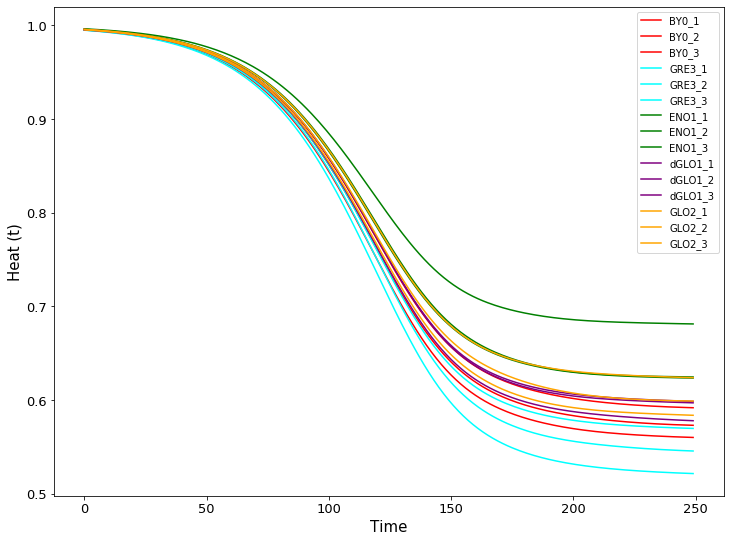

In [40]:
f, ax = plt.subplots(figsize=(12,9))

# Heat Diffusion of the networks
for i in G_heat:
    if i.startswith('BY'):
        plt.plot(G_heat[i], color = 'red')
    if i.startswith('GRE3'):
        plt.plot(G_heat[i], color = 'cyan')
    if i.startswith('ENO1'):
        plt.plot(G_heat[i], color = 'green')
    if i.startswith('dGLO1'):
        plt.plot(G_heat[i], color = 'purple')
    if i.startswith('GLO2'):
        plt.plot(G_heat[i], color = 'orange')
        
plt.xlabel('Time', fontsize=15)
plt.ylabel('Heat (t)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(G_heat.keys())
plt.show()


In [41]:
heat_df
#Non-condensed distance matrix between the different samples

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
BY0_1,0,0.201488,0.360995,0.248859,0.483804,0.751439,0.904245,0.318307,0.299764,0.049709,0.033468,0.156187,0.071408,0.31054,0.101669
BY0_2,0.201488,0,0.160101,0.0492907,0.283226,0.550219,1.10549,0.519609,0.500622,0.247767,0.229918,0.0463397,0.272485,0.511559,0.10053
BY0_3,0.360995,0.160101,0,0.115442,0.132532,0.393228,1.26383,0.678471,0.658856,0.406112,0.388477,0.205149,0.431822,0.669977,0.259684
GRE3_1,0.248859,0.0492907,0.115442,0,0.23549,0.502782,1.15259,0.566569,0.547801,0.294764,0.27663,0.0933154,0.320013,0.558625,0.147752
GRE3_2,0.483804,0.283226,0.132532,0.23549,0,0.268233,1.38771,0.801592,0.783143,0.530191,0.511989,0.328643,0.554817,0.79389,0.383039
GRE3_3,0.751439,0.550219,0.393228,0.502782,0.268233,0,1.65536,1.06933,1.05051,0.797426,0.779352,0.595722,0.822459,1.06138,0.650318
ENO1_1,0.904245,1.10549,1.26383,1.15259,1.38771,1.65536,0,0.586189,0.605015,0.858025,0.876023,1.05977,0.833558,0.594012,1.00521
ENO1_2,0.318307,0.519609,0.678471,0.566569,0.801592,1.06933,0.586189,0,0.0264374,0.272488,0.290259,0.473917,0.247799,0.0162864,0.41926
ENO1_3,0.299764,0.500622,0.658856,0.547801,0.783143,1.05051,0.605015,0.0264374,0,0.253111,0.271241,0.454861,0.229535,0.0127312,0.400327
dGLO1_1,0.049709,0.247767,0.406112,0.294764,0.530191,0.797426,0.858025,0.272488,0.253111,0,0.0189215,0.201831,0.0351054,0.264019,0.147524


### GCD-11 Analysis - Graphlet Correlation Distance of 11 different non-redundant orbits (maximum of 4-node graphlets) 

#### Very quick explanation

This methods considers 11 of the 15 possible orbits (since the other 4 are redundant - 3, 12, 13, 14) of 2 to 4-node graphlets - check image below. Nodes with the same colour in the same graphlet are 'automorphic' in the sense that they are in the 'same' relative position.  5-node graphlets were excluded to diminish dependencies between graphlets which add noise (according to the authors - 1st paper below). With these orbits, we can build a Graphlet Degree Vector for each node that is composed by the number of times a node is present in each of the 11 types of orbits. These are the rows of a Dataframe with 11 columns (for one network). This is what the calculating_orbits function does (except it returns a dict of dicts instead of a dataframe).

From this dataframe, the spearman correlation between each pair of the 11 columns is calculated to generate a 11x11 matrix - the Graphlet Correlation Matrix (GCM). The GCM is symmetric so only one half of the matrix is informative. This, according to the authors, is the signature of the network topology by this method (since networks with different kinds of connections/topologies will have different patterns of orbits and therefore correlations - stored in G_corrMat. The usual distance calculation between the different 'signatures' can then give the distance between the different networks which is ideal to build directly a dendrogram.

However, unlike what was done for the heat diffusion, we don't want a distance matrix to be our dataset for supervised methods. So, a dataset was made where the GCM signature of each network was fully maintained by making a columns from the informative half of the GCM where each row has the name 'n-m' where n and m are the names of orbits and the value in that row is the spearman correlation between those two orbits in the network. This makes it so every network is reduced to a dataset of just 60 features that simbolize the topology of said network.

Useful papers for detailed explanations: 
- Revealing the Hidden Language of Complex Networks - GCD-11 - probably the best one
- Uncovering Biological Network Function via Graphlet Degree Signatures - some details on graphlet signatures
- Comparing methods for comparing networks - many different methods

<img src="Graphlets.png" width="800">

In [42]:
G_CorrMat = {}
for i in G:
    # For 1 network
    orbits_t = calculating_orbits(G[i]) # Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T # Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] # Calculating spearman correlation to obtain 11x11 signature of the network - GCM
    G_CorrMat[i] = np.triu(corrMat_ar) # Both parts of the matrix are equal, so reducing the info to the upper triangle

In [43]:
# Pulling the signature orbit n (u) - orbit m (v) correlations from the upper triangular matrix of the GCM
G_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] # orbit names

# Making the signature into a column of the secondary dataset
for i in G_CorrMat:
    samp_col = {}
    for u in range(len(G_CorrMat[i])):
        for v in range(u+1, len(G_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = G_CorrMat[i][u,v]
        G_CorrMat_df[i] = samp_col

# Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_df = pd.DataFrame.from_dict(G_CorrMat_df)
corrMat_df

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
0-1,0.921535,0.920353,0.906366,0.923223,0.941348,0.930193,0.896267,0.913440,0.905960,0.915762,0.920995,0.927970,0.922100,0.917193,0.927041
0-2,0.884617,0.886841,0.877346,0.898274,0.906022,0.912313,0.846461,0.871998,0.866841,0.883470,0.875530,0.893765,0.881762,0.882067,0.895198
0-4,0.879996,0.884615,0.872159,0.900438,0.904297,0.896793,0.831383,0.853964,0.856504,0.872279,0.869044,0.871558,0.882283,0.860024,0.865280
0-5,0.862951,0.868714,0.859585,0.885750,0.895966,0.898354,0.804475,0.833466,0.838387,0.852968,0.853574,0.859536,0.861367,0.855389,0.875463
0-6,0.821220,0.822446,0.811400,0.868801,0.874609,0.866530,0.799975,0.806442,0.803071,0.823218,0.826676,0.825461,0.821289,0.818918,0.819975
0-7,0.721699,0.729978,0.730101,0.749441,0.786706,0.784112,0.671629,0.721964,0.706786,0.751567,0.747931,0.741601,0.693633,0.691792,0.720144
0-8,0.711196,0.749889,0.741875,0.774235,0.787676,0.789622,0.707303,0.736829,0.749113,0.762843,0.733317,0.764013,0.714812,0.734316,0.728455
0-9,0.718139,0.729512,0.724883,0.780172,0.813993,0.786286,0.690393,0.720960,0.728048,0.771315,0.774347,0.748261,0.719925,0.707090,0.694879
0-10,0.663047,0.703611,0.680134,0.736126,0.760307,0.730436,0.652531,0.671753,0.683399,0.703673,0.714681,0.684226,0.642991,0.649517,0.653376
0-11,0.650314,0.695835,0.670142,0.725881,0.746668,0.718649,0.635023,0.657402,0.670124,0.700053,0.704848,0.680115,0.635440,0.641523,0.647382


### Global metadata for consistency between tables and plots

Finally, only now are the labels of each group added making the dataframe a CDL Accessor.

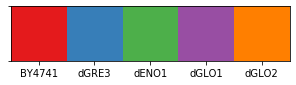

In [44]:
# Adding the labels of the groups to each DataFrame
mtl.add_labels(degree_df, labels = labels)
mtl.add_labels(betw_df, labels = labels)
mtl.add_labels(closeness_df, labels = labels)
mtl.add_labels(groups_df, labels = labels)
mtl.add_labels(heat_df, labels = labels)
mtl.add_labels(corrMat_df, labels = labels)

# Useful variables for later on
sample_names = degree_df.cdl.samples
all_labels = degree_df.cdl.labels
unique_labels = degree_df.cdl.unique_labels

# customize these colors
#colours = cm.get_cmap('nipy_spectral', 5)(range(5))
colours = sns.color_palette('Set1', 9)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

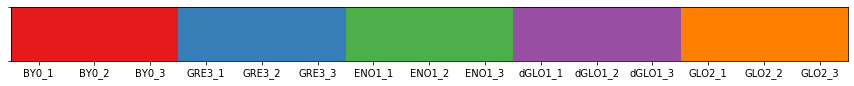

In [45]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

In [46]:
#Example of a centrality measure dataframe
degree_df

label          BY4741              dGRE3                dENO1                \
                BY0_1 BY0_2 BY0_3 GRE3_1 GRE3_2 GRE3_3 ENO1_1 ENO1_2 ENO1_3   
C11H23NO2        1.20   1.2  1.20   2.20    2.2    2.2    1.2    1.2    1.2   
C4H10O3S3        1.50   0.0  1.50   0.00    0.0    0.0    0.0    0.0    0.0   
C9H17NO4         2.00   2.0  1.50   1.50    0.5    0.5    0.5    1.5    0.5   
C8H17N3O3        1.75   0.5  0.75   0.75    1.5    0.5    0.0    0.0    0.0   
C6H10N2S3        0.20   0.2  0.20   0.00    0.0    0.0    0.0    0.0    0.0   
...               ...   ...   ...    ...    ...    ...    ...    ...    ...   
C18H44N8OS9      0.00   0.0  0.00   0.00    0.0    0.0    0.0    0.0    0.0   
C20H17N2O13PS5   0.00   0.0  0.00   0.00    0.0    0.0    0.0    0.0    0.0   
C24H23N19S7      0.00   0.0  0.00   0.00    0.0    0.0    0.0    0.0    0.0   
C22H40O12S10     0.00   0.0  0.00   0.00    0.0    0.0    0.0    0.0    0.0   
C41H87N15O2      0.00   0.0  0.00   0.00    0.0    0.0    0.0    0.0    0.0   

label            dGLO1                  dGLO2                
               dGLO1_1 dGLO1_2 dGLO1_3 GLO2_1 GLO2_2 GLO2_3  
C11H23NO2          1.2     1.2     1.2   1.20    1.2   1.20  
C4H10O3S3          0.0     0.0     0.0   0.00    0.0   0.00  
C9H17NO4           1.5     1.5     1.5   0.50    0.5   0.50  
C8H17N3O3          0.0     0.0     0.0   0.25    0.0   0.75  
C6H10N2S3          0.0     0.0     0.0   0.00    0.0   0.00  
...                ...     ...     ...    ...    ...    ...  
C18H44N8OS9        0.0     0.0     0.0   0.00    0.0   0.00  
C20H17N2O13PS5     0.0     0.0     0.0   0.00    0.0   0.00  
C24H23N19S7        0.0     0.0     0.0   0.00    0.0   0.00  
C22H40O12S10       0.0     0.0     0.0   0.00    0.0   0.00  
C41H87N15O2        0.0     0.0     0.0   0.00    0.0   0.00  

[1645 rows x 15 columns]

## Unsupervised and Supervised Statistical Analysis 

### Unsupervised Statistical Analysis

### (Agglomerative) Hierarchical Cluster Analysis 

HCA analysis and plotting dendrograms based on the secondary datasets built - degree, betweenness centrality, closeness centrality, MDB influence, NetLSD (already a distance matrix in this case, the distance matrix is used since no better option is available) and GCD-11 for both the TF and NM networks.

Dendrograms were plotted with Euclidian distance metric and UPGMA linkage.

In [47]:
def plot_dendogram(Z, title='', color_threshold=None):
    """Plot a dendrogram from a Z linkage matrix with a chosen title and a chosen color_threshold."""
    
    plt.rcParams['lines.linewidth'] = 1.3
    
    fig = plt.figure(figsize=(10,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=13, above_threshold_color='b', leaf_rotation=30,
                         color_threshold=color_threshold)#,  orientation='left')
    
    # Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 16)
    xlbls = ax.get_xmajorticklabels()

    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])
    

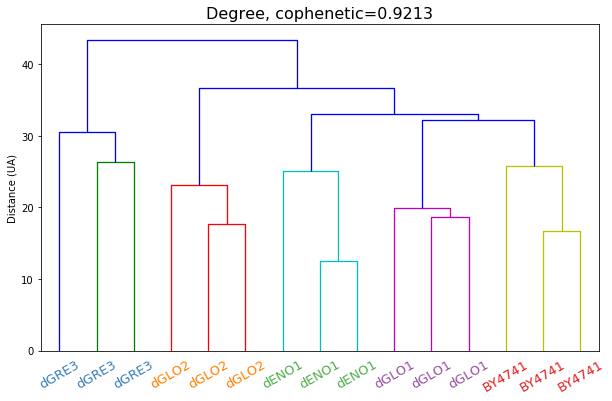

In [48]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
degree_df_dist = dist.pdist(degree_df.T, metric='euclidean')
#degree_df_jdist = dist.pdist(degree_df.T, metric='jaccard')
Z_degree = hier.linkage(degree_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_degree, degree_df_dist)[0]

# Plot the dendrogram
title = f'Degree, cophenetic={coph:.4f}'
plot_dendogram(Z_degree, title)

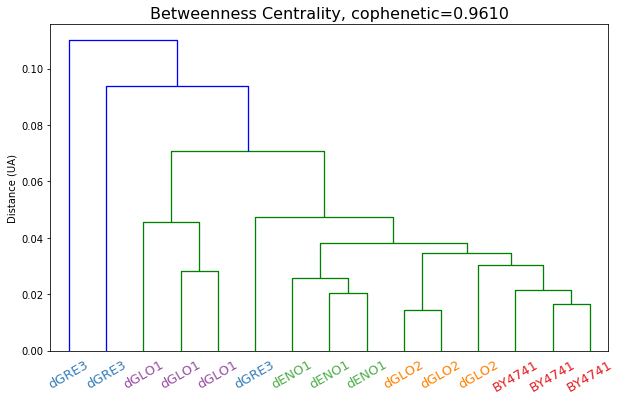

In [49]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
betw_df_dist = dist.pdist(betw_df.T, metric='euclidean')
#betw_df_jdist = dist.pdist(betw_df.T, metric='jaccard')
Z_betw = hier.linkage(betw_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_betw, betw_df_dist)[0]

# Plot the dendrogram
title = f'Betweenness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z_betw, title)

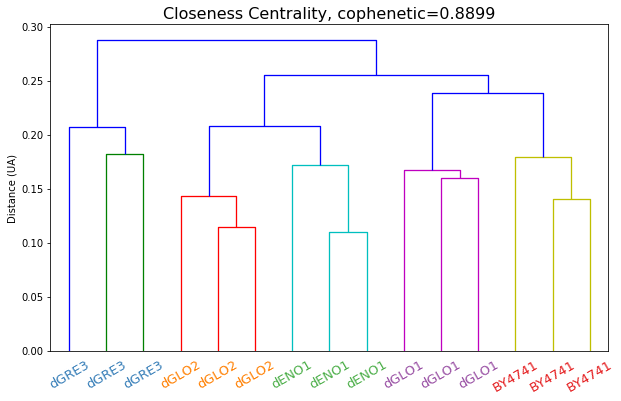

In [50]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
closeness_df_dist = dist.pdist(closeness_df.T, metric='euclidean')
#closeness_df_jdist = dist.pdist(closeness_df.T, metric='jaccard')
Z_closeness = hier.linkage(closeness_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_closeness, closeness_df_dist)[0]

# Plot the dendrogram
title = f'Closeness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z_closeness, title)

Summing all the distances between the different sample with the 3 centrality measures

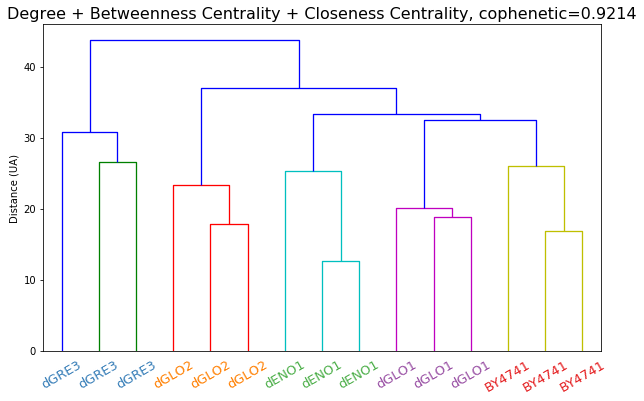

In [51]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
all_df_dist = degree_df_dist + betw_df_dist + closeness_df_dist
Z = hier.linkage(all_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, all_df_dist)[0]

# Plot the dendrogram
title = f'Degree + Betweenness Centrality + Closeness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

Group Influence dendrogram

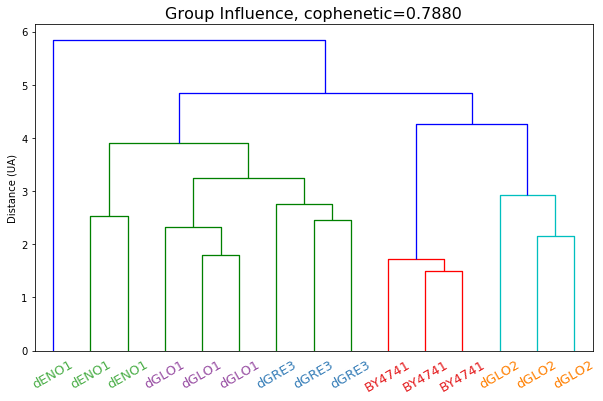

In [52]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
groups_df_dist = dist.pdist(groups_df.T, metric='euclidean')
Z_groups = hier.linkage(groups_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_groups, groups_df_dist)[0]

# Plot the dendrogram
title = f'Group Influence, cophenetic={coph:.4f}'
plot_dendogram(Z_groups, title)

Heat Diffusion Dendrogram

In [53]:
heat_df_short = dist.squareform(heat_df) # Condensing the distance matrix
# Be careful when running these 3 cells, running them weirdly can lead to kernel dying for unknown reasons.

In [54]:
# Build the linkage matrix of the HCA
Z_heat = hier.linkage(heat_df_short, method='average')

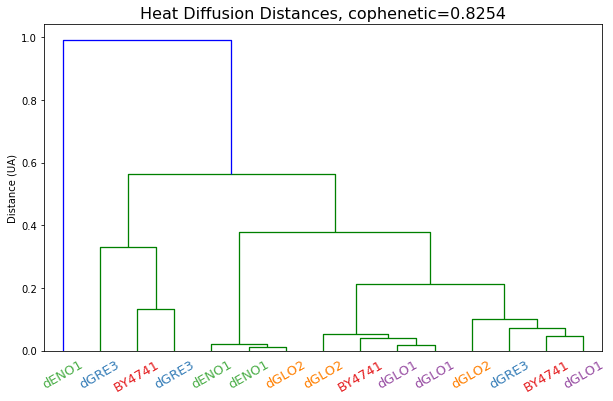

In [55]:
# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_heat, heat_df_short)[0] #method average seems to lead to higher coefficients

# Plot the dendrogram
title = f'Heat Diffusion Distances, cophenetic={coph:.4f}'
plot_dendogram(Z_heat, title)

GCD-11 dendrogram

In [56]:
# Calculating the distance matrix (between the samples) of the secondary dataset

#Both ways are equal - 2nd you get the condensed distance matrix right away

#1st way
#corrMat_df_dist = pd.DataFrame(index=G_CorrMat.keys(), columns=G_CorrMat.keys())

#for g in G_CorrMat:
#    for i in G_CorrMat:
#        corrMat_df_dist.loc[g,i] = np.linalg.norm(G_CorrMat[g]-G_CorrMat[i])
#corrMat_df_dist

#2nd way
corrMat_df_dist = dist.pdist(corrMat_df.T)

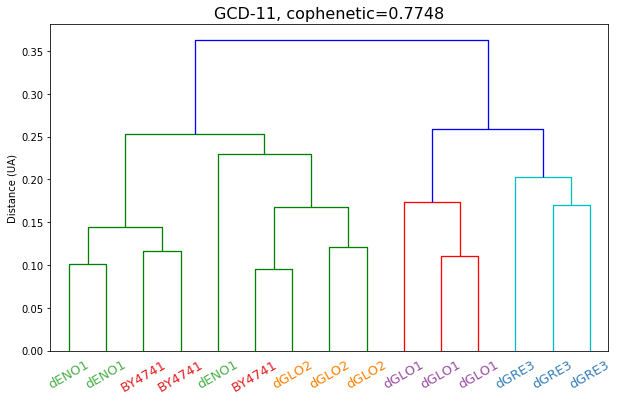

In [57]:
# Build the linkage matrix of the HCA
Z_GCD = hier.linkage(corrMat_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_GCD, corrMat_df_dist)[0]

# Plot the dendrogram
title = f'GCD-11, cophenetic={coph:.4f}'
plot_dendogram(Z_GCD, title)

### Comparing HCA Discrimination

Using 3 different metrics explained in the dissertation:

- Discrimination Distance
- Correct Clustering Percentage
- Correct First Cluster

Functions applied here (`dist_discrim` and `correct_1stcluster_fraction`) from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct (Group) Clustering definition - samples of a group all clustered together before any other sample clustered with a sample of said group.

In [58]:
# Linkage Matrices of the different dendrograms built from the secondary datasets
Z = (Z_degree, Z_betw, Z_closeness, Z_groups, Z_heat, Z_GCD)

# Condensed distance matrices between samples for each of the secondary datasets
dists = (degree_df_dist, betw_df_dist, closeness_df_dist, groups_df_dist, heat_df_short, corrMat_df_dist)

# Names for each of the secondary datasets
colnames = ['Degree', 'Betweenness', ' Closeness', 'Group Influence', 'Heat Diffusion', 'GCD-11']

In [59]:
disc_average = np.zeros((1,6)) # Discrimination Distance Storing
disc_correct = np.zeros((1,6)) # Correct Clustering Percentage Storing
disc_1stclust = np.zeros((1,6)) # Correct First Cluster Percentage Storing

for i in range(len(Z)):
    data = degree_df
    
    # Discrimination Distance and Correct Clustering Percentage
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  # all samples have the same order
    disc_average[0,i] = discrim[0]
    #disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] # all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    
    # Correct First Cluster Percentage
    disc_1stclust[0,i] = ma.correct_1stcluster_fraction(data, Z[i]) # all samples have the same order
    
# Transforming results into DataFrames    
disc_average = pd.DataFrame(disc_average, index = ['Discriminatio Distance'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct * 100 / 5, index = ['% correct groupings'], columns = colnames) # Transforming into %s
disc_1stclust = pd.DataFrame(disc_1stclust * 100, index = ['% correct 1st cluster'], columns = colnames) # Transforming into %s

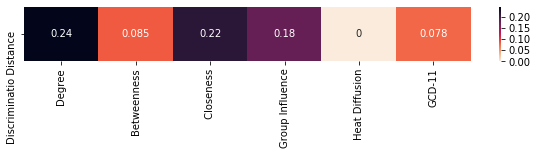

In [60]:
# Discrimination Distance
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

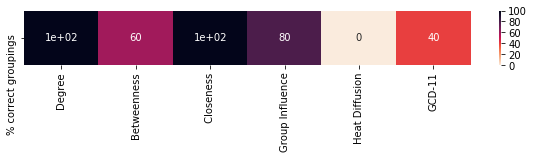

In [61]:
# Correct Clustering Percentage Storing
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

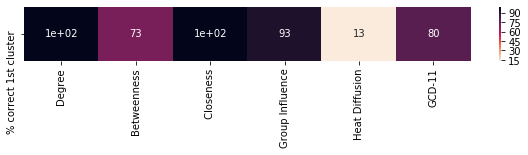

In [62]:
# Correct First Cluster Percentage Storing
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_1stclust, annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [63]:
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means Clustering Analysis

K-means clustering analysis was applied by using the appropriate functions of the scikit-learn as done in the following cells.

In [64]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering analysis and how samples are separated 

Use of the sci-kit learn Python package - sklearn. 

Cluster number equal to the amount of groups. Default parameters except number of clusters.

K-means clustering analysis has an intrinsically random side to it depending on the starting position of the clusters and existence of local minima.

In [65]:
# Setting the K-means Clustering
Kmean = skclust.KMeans(n_clusters=5)

In [66]:
# Fitting the K-means clustering analysis to a dataset
a = Kmean.fit(degree_df.T)
a = Kmean.fit(corrMat_df.T)
a.inertia_ # Results of the function to be minimized by the K-means algorithm
# sum of squared distances of the samples to the cluster centers

0.12283145051412755

In [67]:
# Example of the cluster mades with the K-means clustering analysis. Samples identified by their groups
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{2: ['BY4741', 'dGLO2', 'dGLO2', 'dGLO2'],
 1: ['BY4741', 'BY4741', 'dENO1', 'dENO1'],
 3: ['dGRE3', 'dGRE3', 'dGRE3'],
 4: ['dENO1'],
 0: ['dGLO1', 'dGLO1', 'dGLO1']}

### K-means clustering applied to all networks

Using 3 different metrics explained in the dissertation:

- Discrimination Distance (for K-means clustering)
- Correct Clustering Percentage (for K-means clustering)
- Adjusted Rand Index (calculated by scikit-learn - `adjusted_rand_index`)

Due to the randomness of the K-means clustering analysis (position of initial cluster centers leading to different local minima), this analysis was iterated 150 times and the 10% of analysis that led to a greater minimization of the objective function - sum of squared distances of the samples to the cluster centers - were chosen to calculate the 3 different metrics mentioned. The Median of the different metrics were taken as the final results.

`Kmeans_discrim` function applied here from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct clustering definition - K-means Cluster contains all and only the samples of a single group.

A method similar to the Discrimination Distance and Correct Clustering percentage performed in the HCA was made. Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero and the groups isn't correctly clustered. Therefore, this method is harsher than the Discrimination Distance and Correct Clustering Percentage for HCA.  Thus, the Correct Clustering Percentage is expected to be lower in this case

The Discrimination Distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. It is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean of the Discrimination Distances of all groups is then a measure of the global Discrimination Distance. 

In [68]:
# Datasets to apply the K-means Clustering Analysis
Data = (degree_df, betw_df, closeness_df, groups_df, heat_df, corrMat_df)

In [69]:
disc_average = np.zeros((1,6)) # Discrimination Distance
#disc_median = np.zeros((1,6))
disc_correct = np.zeros((1,6)) # Correct Clustering Percentage
disc_rand = np.zeros((1,6)) # Adjusted Rand Index

for i in range(len(Data)):
    discrim = ma.Kmeans_discrim(Data[i], method = 'average', iter_num=150, best_fraction=0.1)
    
    # Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    for j in discrim:
        average.append(discrim[j][0]) # Discrimination Distances
        all_correct = np.array(list(discrim[j][1].values()))
        correct.append(len(all_correct[all_correct>0])) # Correct Clustering Percentages
        rand.append(discrim[j][2]) # Adjusted Rand Index
    
    # Putting results into the arrays - median of the best k-means clustering
    disc_average[0,i] = np.median(average) 
    disc_correct[0,i] = np.median(correct)
    disc_rand[0,i] = np.median(rand)

# Transforming into DataFrame
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct * 100 / 5, index = ['% correct groupings'], columns = colnames) # Transforming into %s
disc_rand = pd.DataFrame(disc_rand, index = ['Rand Index'], columns = colnames)

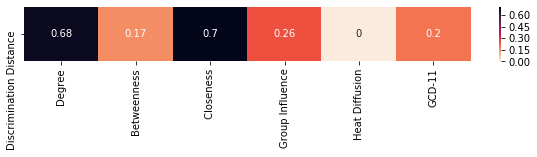

In [70]:
# Discrimination Distance
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

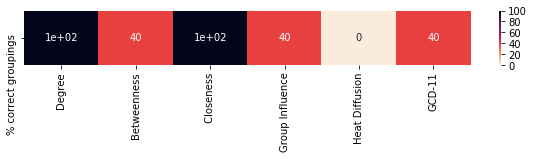

In [71]:
# Correct Clustering Percentage
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

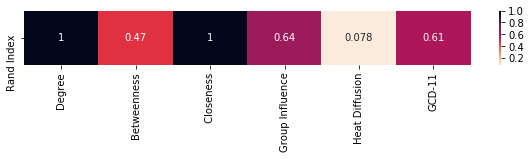

In [72]:
# Adjusted Rand Index
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_rand, annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [73]:
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

## Supervised Statistical Analysis

The Supervised Statistical Analysis methods used will be Random Forest and PLS-DA. The performance of the models/classifiers built will be evaluated by their predictive accuracy (which will always be estimated by internal stratified 3-fold cross-validation).

Internal stratified 3-fold cross-validation was used to estimate the model's performance since that is maximum number possible since every group of samples only has 3 replicates in the dataset.

The datasets that will be analyzed:

In [74]:
# Centralize data information in a dictionary
datasets = {'degree': degree_df, 'betweenness': betw_df, 'closeness' : closeness_df, 'groups': groups_df, 'heat_dif': heat_df,
           'GCD-11': corrMat_df}

## Random Forests

### Test number of trees needed for predictive accuracy convergence for the different secondary datasets

Random Forest models with different number of trees will be built to assess when the predictive accuracy of the different models stops increasing with higher number of trees.

Grid search of number of trees from 10 to 400 for the random forests. See where the cross-validation estimated predictive accuracy stops improving for each one.

In [75]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,400,10)} # Models will be built from 10 to 400 trees in 10 tree intervals.

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [76]:
param = []
test_score = []

# For each dataset,building the Random Forest models with the different number of trees
# and storing the predictive accuracy (estimated by 3-fold cross-validation)
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting degree ... Done!
Fitting betweenness ... Done!
Fitting closeness ... Done!
Fitting groups ... Done!
Fitting heat_dif ... Done!
Fitting GCD-11 ... Done!


Performance (Predictive Accuracy) based on number of trees - Yeast Dataset


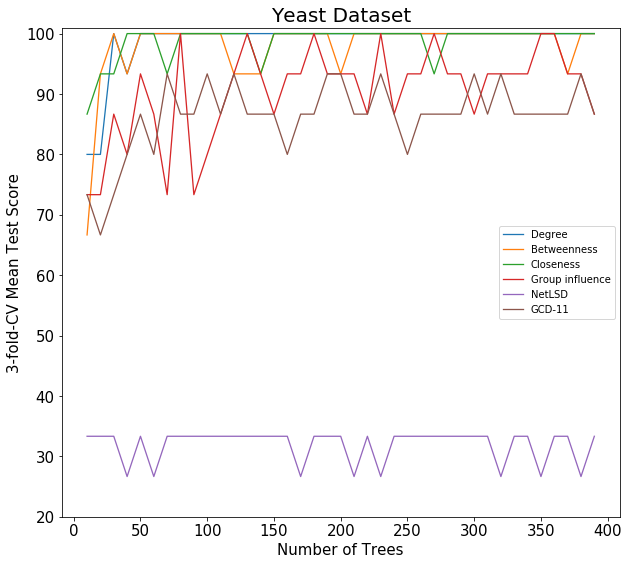

In [77]:
# Plotting the results and adjusting parameters of the plot
f, ax = plt.subplots(figsize=(10,9))
for i in range(6):
    plt.plot(param[i], test_score[i]*100)
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('Degree', 'Betweenness', 'Closeness', 'Group influence', 'NetLSD', 'GCD-11'))
plt.ylim(20,101)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Yeast Dataset', fontsize=20)
print('Performance (Predictive Accuracy) based on number of trees - Yeast Dataset')

### Random Forest Application

Stores predictive accuracy of the models, standard deviation of the predictive accuracy (across the iterations) and an ordered list of the most to least important features (average across the iterations) in building the model according to the Gini Importance calculated by scikit-learn (all estimated by stratified 3-fold cross-validation) of each of the 200 iterations (with different samplings of the 3 folds) of models built for each secondary dataset.

Iterations are made to randomly sample the folds in 3-fold cross-validation - more combinations of training and test samples are used to offset the small (in terms of samples per group) dataset.

Use of the `simple_RF` function of multianalysis.py (uses Random Forest algorithm from scikit-learn) where each step of the process is better explained.

In [78]:
# Preparations of dicts:
Scores = {} # Stores Predictive Accuracy
Scores_std = {} # Stores Predictive Accuracy's Standard Deviation
Imp_feat = {} # Stores ordered list of most to least important feature to build the model

# Application of the Random Forests for each secondary dataset
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data)#, iter_num = 200) 

    Scores[name] = rf
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done')    

Fitting random forest for degree ...done
Fitting random forest for betweenness ...done
Fitting random forest for closeness ...done
Fitting random forest for groups ...done
Fitting random forest for heat_dif ...done
Fitting random forest for GCD-11 ...done


Performance of each predictive model

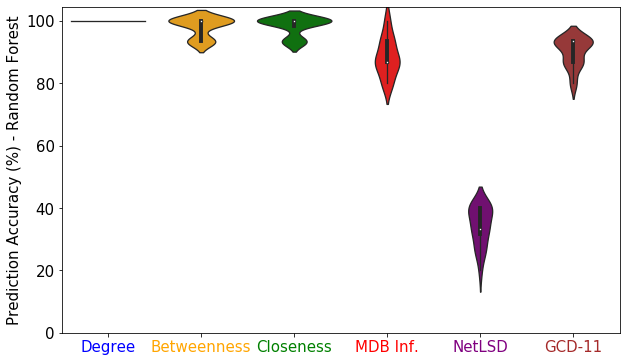

In [79]:
# Violin plot of the distribution of the predictive accuracy (in %) across 200 iterations of randomly sampled folds for each 
# secondary dataset and adjustments to the parameters of the plot.
f, ax = plt.subplots(figsize=(10,6))
data = pd.DataFrame.from_dict(Scores)*100
data.columns = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.','NetLSD', 'GCD-11']
colors = ['blue','orange','green','red','purple','brown']
sns.violinplot( data = data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - Random Forest', fontsize = 15)
plt.ylim([0,104.5])
ax.tick_params(axis='x', which='major', labelsize = 15)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

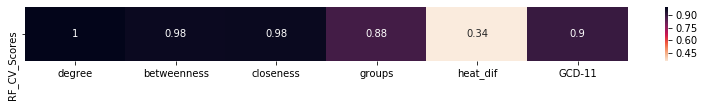

In [80]:
# Average prediction accuracy of the models built for each of the secondary datasets
# estimated by stratified 3-fold cross validation
Scores_A = {}
for i in Scores:
    Scores_A[i] = np.mean(Scores[i])

Scores_H = pd.DataFrame(list(Scores_A.values()), index = Scores_A.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])

In [81]:
Imp_feat['groups'] # Important groups whose influence can be characteristic of each network

[(9, 0.08043597679933605, 'PO3H'),
 (5, 0.07745465329091225, 'NCH'),
 (1, 0.07563453850417642, 'CH2'),
 (10, 0.07514646536923357, 'NH3(-O)'),
 (2, 0.07181817903524874, 'CO2'),
 (7, 0.06880062165249902, 'S'),
 (8, 0.06855861681526985, 'CONH'),
 (12, 0.0679813298035977, 'CO'),
 (0, 0.06721342687306817, 'H2'),
 (3, 0.0649053320698687, 'O'),
 (4, 0.06379721319310176, 'CHOH'),
 (13, 0.061880400739603346, 'C2H2O'),
 (6, 0.058795297164203175, 'O(-NH)'),
 (14, 0.05324206346306056, 'H2O'),
 (11, 0.04433588522682068, 'SO3')]

#### Extracting a single decision tree

Decision Tree


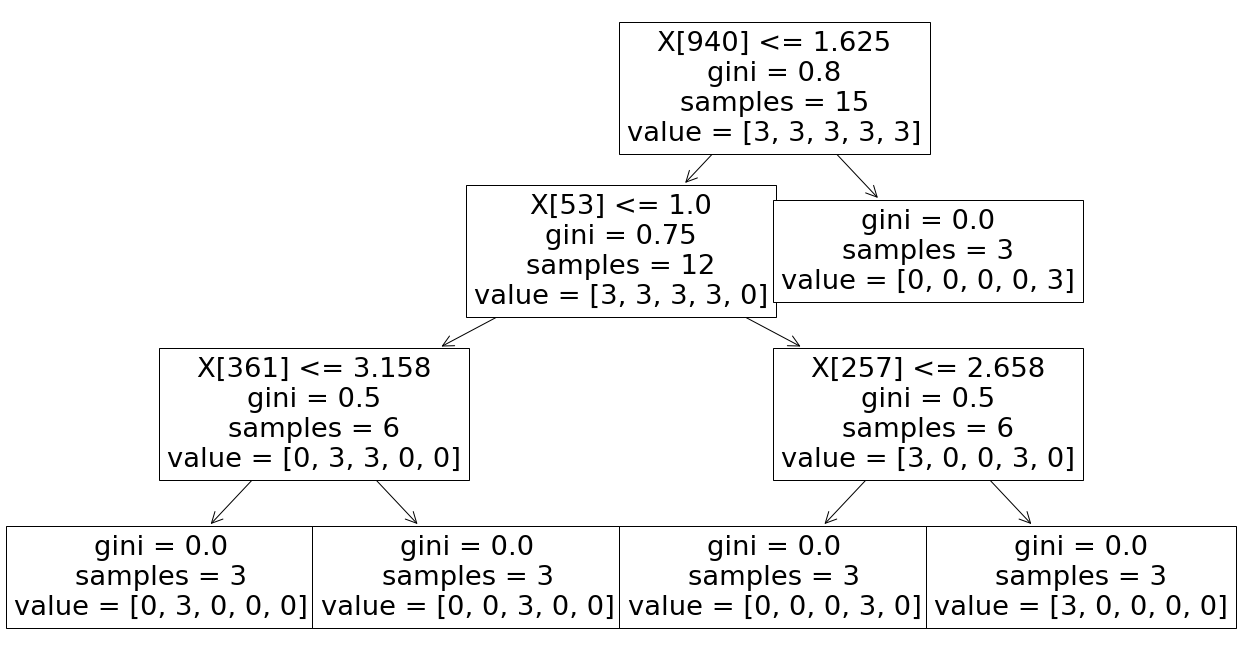

In [82]:
from sklearn.model_selection import train_test_split
import sklearn.ensemble as skensemble
X_train, X_test, y_train, y_test = train_test_split(datasets['degree'].T, all_labels, test_size=1/3)
rf = skensemble.RandomForestClassifier(n_estimators = 200)
#rf.fit(X_train, y_train)
rf.fit(datasets['degree'].T, all_labels)

from sklearn import tree
fig = plt.figure(figsize=(22,12))
#clf = rf.estimators_[2].fit(X_train, y_train)
clf = rf.estimators_[2].fit(datasets['degree'].T, all_labels)
tree.plot_tree(clf)
print('Decision Tree')

## PLS-DA - Classifiers

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong) with one-hot encoding.

PLS-DA models were built using the PLSRegression module of scikit-learn while imposing a decision rule where the group corresponding to the maximum value in the predicted regression vector (one value for each group) obtained for a test sample (ypred) is chosen. 

In [83]:
matrix = pd.get_dummies(all_labels)
matrix

,BY4741,dENO1,dGLO1,dGLO2,dGRE3
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
6,0,1,0,0,0
7,0,1,0,0,0
8,0,1,0,0,0
9,0,0,1,0,0


#### Optimization - Search for the best number of components to use

The number of components were optimized by observing the score metric of the PLSRegression of scikit learn, that is, the 1 - PRESS/SS or Q2 of models built with 1 to n components.

PRESS - Predictive Residual Sum of Squares
SS - residual Sum of Squares

Strategy: Perform PLS-DA with different number of components and observe the score (given directly by the method score, inverse relation to the mean-squared error (MSE)) of the models built estimated with stratified 3-fold cross-validation. Then plot the different results obtained and see at which point (number of components) the score starts approaching a "stable maximum value".

To observe details of the `optim_PLS` function - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp - see multianalysis.py file. 

These regression metrics are not suitable to evaluate the performance of the classifier, they were just used to optimize the number of components to build the final PLS-DA models.

In [84]:
%%capture --no-stdout
# Build and extract metrics from models build with different number of components by using the optim_PLS function.
PLS_optim = {}
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 10)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for degree ...done
Optimizing PLS-DA for betweenness ...done
Optimizing PLS-DA for closeness ...done
Optimizing PLS-DA for groups ...done
Optimizing PLS-DA for heat_dif ...done
Optimizing PLS-DA for GCD-11 ...done


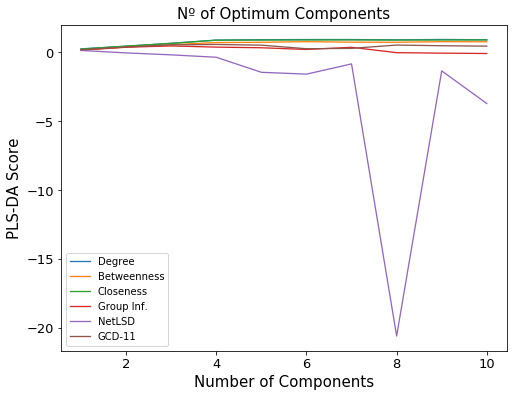

In [85]:
f, ax = plt.subplots(figsize=(8,6))

# Plotting the results and adjusting plot parameters
for name, data in PLS_optim.items():
    plt.plot(range(1,11),data)
    
plt.xlabel('Number of Components', fontsize=15)
plt.ylabel('PLS-DA Score', fontsize=15)
plt.title('Nº of Optimum Components', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(('Degree', 'Betweenness', 'Closeness', 'Group Inf.', 'NetLSD', 'GCD-11'))
plt.show()

5 components were used for the PLS-DA model made after.

### Application of PLS-DA

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule. Models were evaluated according to their predictive accuracy estimated by 3-fold cross-validation.

Use of function `model_PLSDA` of multianalysis.py file. See this file to see the application of this function more in-depth (used `PLSRegression` from scikit-learn).

3 different feature importance metrics (feat_type):

- VIP (Variable Importance/Influence in Projection) - used in dissertation (slowest)
- Coef. (regression coefficients - sum)
- Weights (Sum of the X-weights for each feature)

In [86]:
# Dictionaries to store results
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [87]:
%%capture --no-stdout

# For each secondary dataset, fit PLS-DA models with 5 components on 200 randomly sampled folds (for stratified 3-fold cross
# validation. Store results in dictionaries (results for 200 iterations).
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 5, iter_num = 100, feat_type = 'Coef')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done') 

Fitting PLS-DA for degree ...done
Fitting PLS-DA for betweenness ...done
Fitting PLS-DA for closeness ...done
Fitting PLS-DA for groups ...done
Fitting PLS-DA for heat_dif ...done
Fitting PLS-DA for GCD-11 ...done


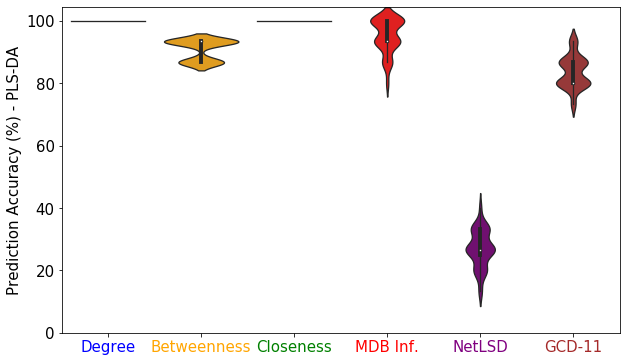

In [88]:
# Plot the distribution of prediction accuracy of the 200 iterations of models built from each of the secondary datasets
# Part of Fig. 3.10
f, ax = plt.subplots(figsize=(10,6))
data = pd.DataFrame.from_dict(PLS_accu) * 100
data.columns = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'NetLSD', 'GCD-11']
colors = ['blue','orange','green','red','purple','brown']
sns.violinplot( data = data, palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - PLS-DA', fontsize = 15)
plt.ylim([0,104.5])
ax.tick_params(axis='x', which='major', labelsize = 15)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
plt.show()

In [89]:
# Average prediction accuracy of the models built for each of the secondary datasets
# estimated by stratified 3-fold cross validation
Accuracy = {}
Accuracy_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.mean(PLS_accu[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])

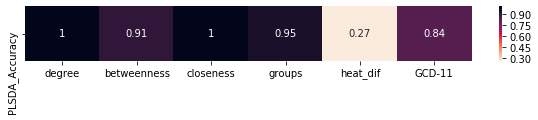

In [90]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])
plt.show()

In [91]:
PLS_feat['groups'] # The main contriuting groups are different from the ones in Random Forests.

[(5, 0.826840041802186, 'NCH'),
 (3, 0.5786073940821707, 'O'),
 (12, 0.569725055163862, 'CO'),
 (13, 0.5321906439023933, 'C2H2O'),
 (8, 0.4538583861299111, 'CONH'),
 (0, 0.4415720119745933, 'H2'),
 (4, 0.40709293373421057, 'CHOH'),
 (9, 0.37980340046462235, 'PO3H'),
 (10, 0.3734659338580612, 'NH3(-O)'),
 (1, 0.36266430538282646, 'CH2'),
 (14, 0.32955533307257595, 'H2O'),
 (2, 0.32211735691088517, 'CO2'),
 (6, 0.2451825984186784, 'O(-NH)'),
 (11, 0.2164446736750698, 'SO3'),
 (7, 0.1977019972272835, 'S')]

### Model with the full dataset and sample representation on the two most important Components/Latent Variables

In [92]:
def plot_PLSDA(principaldf, label_colors, components=(1,2), title="PLS-DA", ax=None):
    "Plot the projection of samples in the 2 main components of a PLS-DA model."

    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    with sns.axes_style("whitegrid"):
        #ax.axis('equal')
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

        unique_labels = principaldf['Label'].unique()

        for lbl in unique_labels:
            subset = principaldf[principaldf['Label']==lbl]
            ax.scatter(subset[col_c1_name],
                       subset[col_c2_name],
                       s=50, color=label_colors[lbl], label=lbl)

        ax.legend(framealpha=1, fontsize='large')
        ax.set_title(title, fontsize=15)

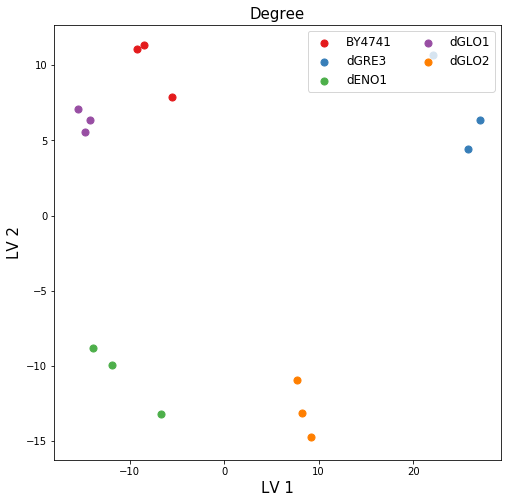

In [93]:
# Degree
n_components = 5

plsreg = ma.PLSscores_with_labels(degree_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Degree", ax=axl)
plt.legend(loc='upper right', ncol=2, fontsize=12)
plt.show()

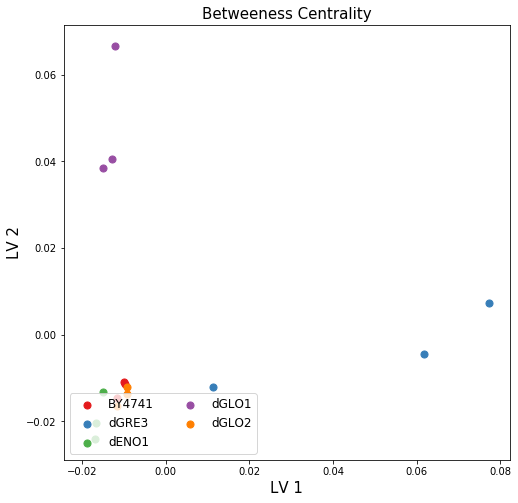

In [94]:
# Betweenness Centrality
n_components = 5

plsreg = ma.PLSscores_with_labels(betw_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Betweeness Centrality", ax=axl)
plt.legend(loc='lower left', ncol=2, fontsize=12)
plt.show()

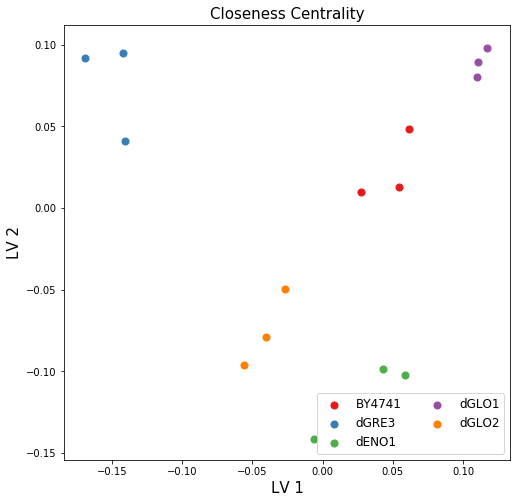

In [95]:
# Closeness Centrality
n_components = 5

plsreg = ma.PLSscores_with_labels(closeness_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Closeness Centrality", ax=axl)
plt.legend(loc='lower right', ncol=2, fontsize=12)
plt.show()

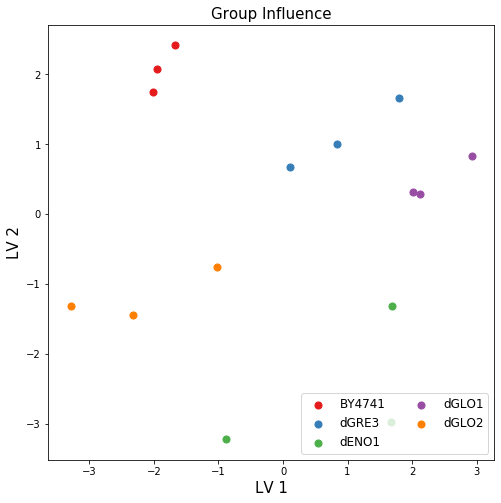

In [96]:
# Group Influence
n_components = 2

plsreg = ma.PLSscores_with_labels(groups_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Group Influence", ax=axl)
plt.legend(loc='lower right', ncol=2, fontsize=12)
plt.show()

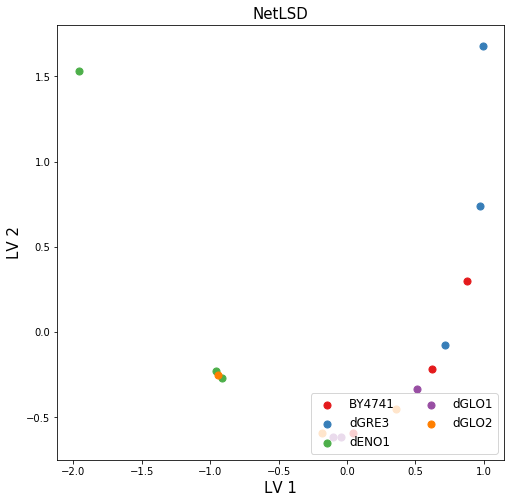

In [97]:
# NetLSD
n_components = 2

plsreg = ma.PLSscores_with_labels(heat_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="NetLSD", ax=axl)
plt.legend(loc='lower right', ncol=2, fontsize=12)
plt.show()

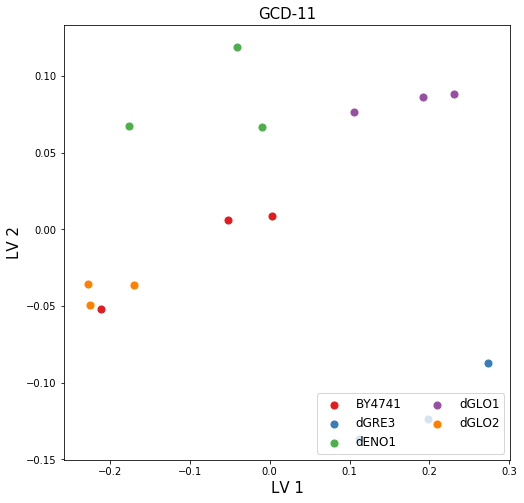

In [98]:
# GCD-11
n_components = 2

plsreg = ma.PLSscores_with_labels(corrMat_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="GCD-11", ax=axl)
plt.legend(loc='lower right', ncol=2, fontsize=12)
plt.show()

## Permutation Tests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is Random Forest or PLS-DA found a significant class structure in the data - assess the significance of the predictive accuracy results. 

For that a random 3-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 1000 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

Initially, permutation tests were made for both the MDiNs made with our transformation list (TF) and MetaNetter's transformation list (MN), however, as was done for the rest of the supervised statistical analyses, only the results for the MDiNs made with our transformation list (TF) are now shown.

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

### Permutation Tests - Random Forests (very slow)

Use of `permutation_RF` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [99]:
CV = {}
PMs = {}
pvalue = {}

all_data = (degree_df, betw_df, closeness_df, groups_df, heat_df, corrMat_df)
names = ('Degree', 'Betweenness', 'Closeness', 'Groups', 'NetLSD', 'GCD-11')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for Degree ...
Done!
Permutation test (Random Forest) for Betweenness ...
Done!
Permutation test (Random Forest) for Closeness ...
Done!
Permutation test (Random Forest) for Groups ...
Done!
Permutation test (Random Forest) for NetLSD ...
Done!
Permutation test (Random Forest) for GCD-11 ...
Done!


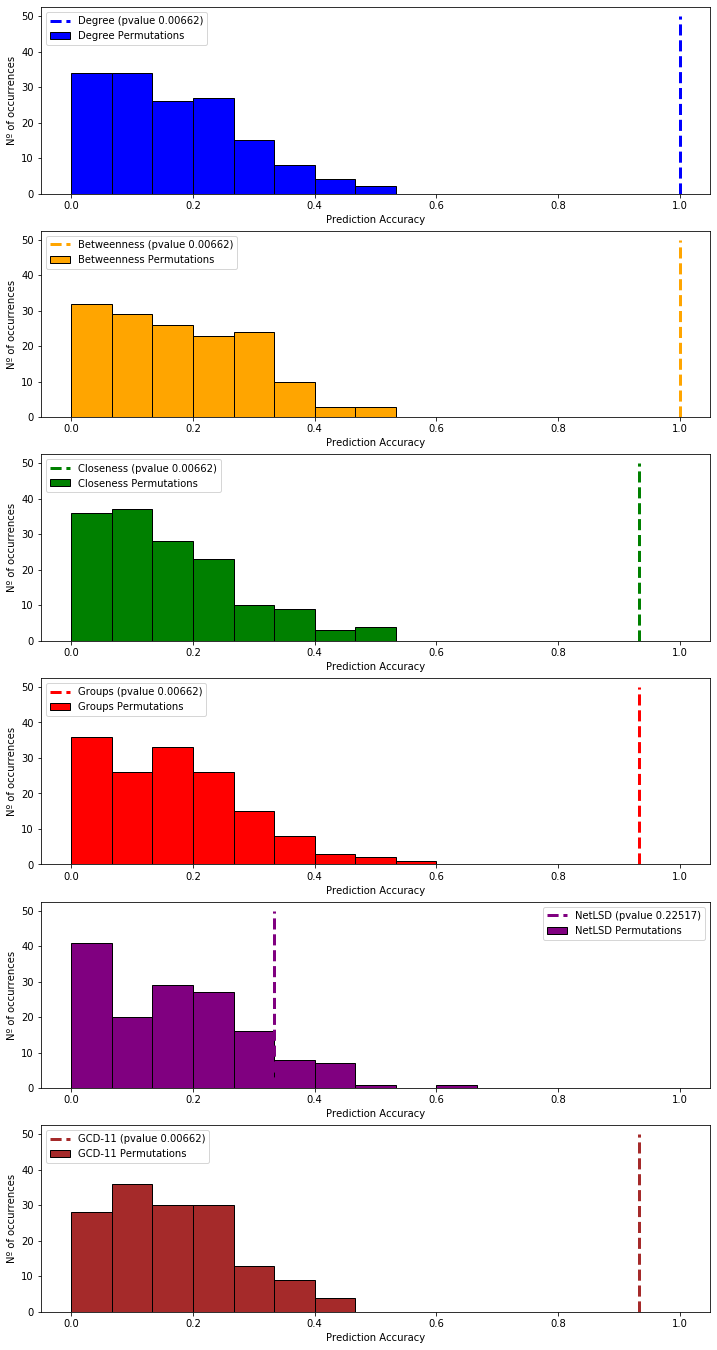

In [100]:
f, axes = plt.subplots(6, 1, figsize = (12,24))

Names = ['Degree', 'Betweenness', 'Closeness', 'Groups', 'NetLSD', 'GCD-11']
colors = ['blue','orange', 'green', 'red', 'purple', 'brown']
quadrant = [axes[0], axes[1], axes[2], axes[3], axes[4], axes[5]]
ylim = [0,50]
n_labels = len(degree_df.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Permutation Tests - PLS-DA

In [101]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

all_data = (degree_df, betw_df, closeness_df, groups_df, heat_df, corrMat_df)
names = ('Degree', 'Betweenness', 'Closeness', 'Groups', 'NetLSD', 'GCD-11')
for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=5, iter_num=150)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for Degree ...
Done!
permutation test (PLS-DA) for Betweenness ...
Done!
permutation test (PLS-DA) for Closeness ...
Done!
permutation test (PLS-DA) for Groups ...
Done!
permutation test (PLS-DA) for NetLSD ...
Done!
permutation test (PLS-DA) for GCD-11 ...
Done!


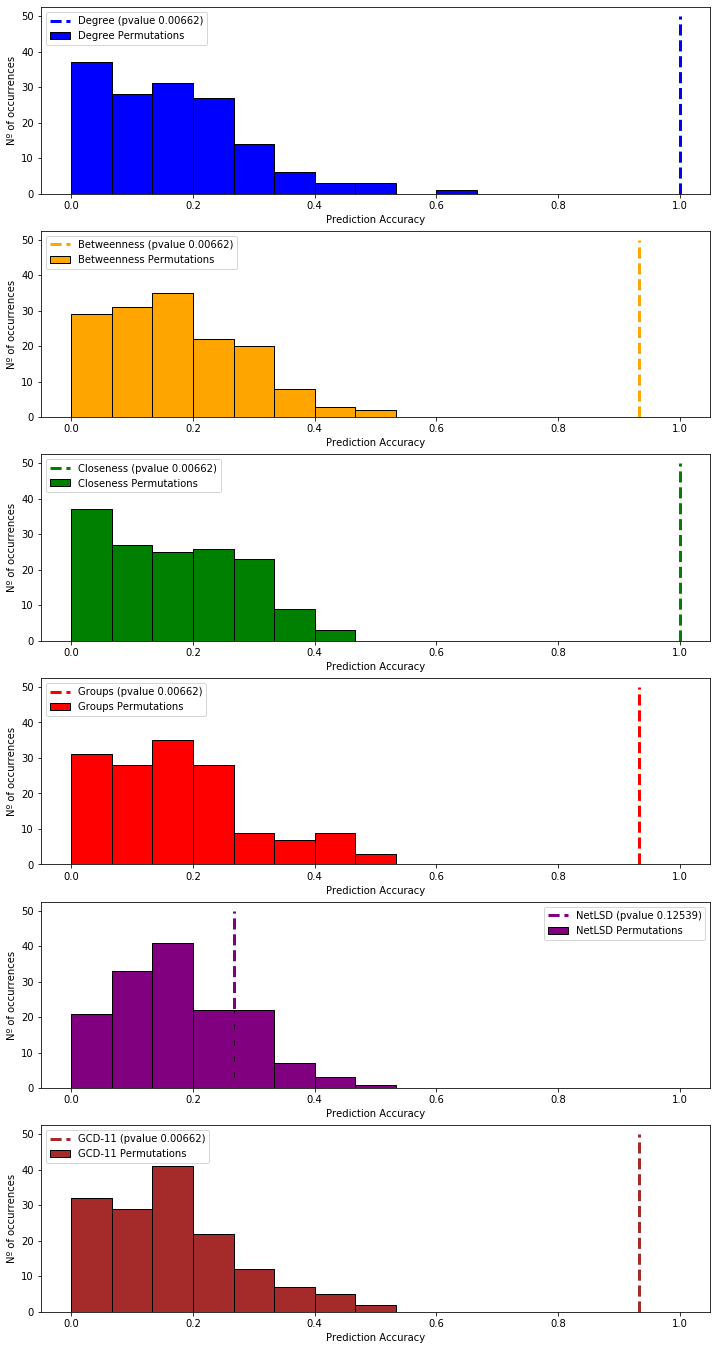

In [102]:
f, axes = plt.subplots(6, 1, figsize = (12,24))

Names = ['Degree', 'Betweenness', 'Closeness', 'Groups', 'NetLSD', 'GCD-11']
colors = ['blue','orange', 'green', 'red', 'purple', 'brown']
quadrant = [axes[0], axes[1], axes[2], axes[3], axes[4], axes[5]]
ylim = [0,50]
n_labels = len(degree_df.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Yeast Dataset Formula Network considering all features in the dataset at the same time

Make the graph considering all formulas that are in the dataset (that appear in at least 2 samples)

In [103]:
formula_df = deformulator(yeast_df)
formula_df.index = yeast_df['Formula']
formula_df

,C,H,O,N,S,P,Cl
Formula,,,,,,,
C12H24O2,12.0,24.0,2.0,0.0,0.0,0.0,0.0
C11H23NO2,11.0,23.0,2.0,1.0,0.0,0.0,0.0
C4H10O3S3,4.0,10.0,3.0,0.0,3.0,0.0,0.0
C9H17NO4,9.0,17.0,4.0,1.0,0.0,0.0,0.0
C8H17N3O3,8.0,17.0,3.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
C26H49O28PS3,26.0,49.0,28.0,0.0,3.0,1.0,0.0
C27H38N16O10S6,27.0,38.0,10.0,16.0,6.0,0.0,0.0
C51H57NO15P2,51.0,57.0,15.0,1.0,0.0,2.0,0.0


In [104]:
# Set up the graph
Gr = nx.Graph()
Gr.add_nodes_from(formula_df.index)

In [105]:
# Adding the edges and the 'weight_inv' attribute
edge_assembler(formula_df,Gr,depth=1)
inverse_weight_attributer(Gr)

In [106]:
l = BY2
l.index = l['Formula']
# Select all the formulas that appear in a certain sample (in this case, replicate nº2 of the BY strain) and represent them with
# a different color to see its distribution.

In [107]:
# Colors for nodes - blue (general nodes) and red (nodes that are in sample nº2 of BY strain)
color_map = []
for node in Gr:
    if node in l.index:#BY2['Formula']:
        color_map.append('red') 
    else: 
        color_map.append('blue')
        
# Colors for edges
edge_colors =  [group_colors[lbl] for lbl in nx.get_edge_attributes(Gr,'group').values()]

C:\Users\francisco\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\francisco\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\Users\francisco\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


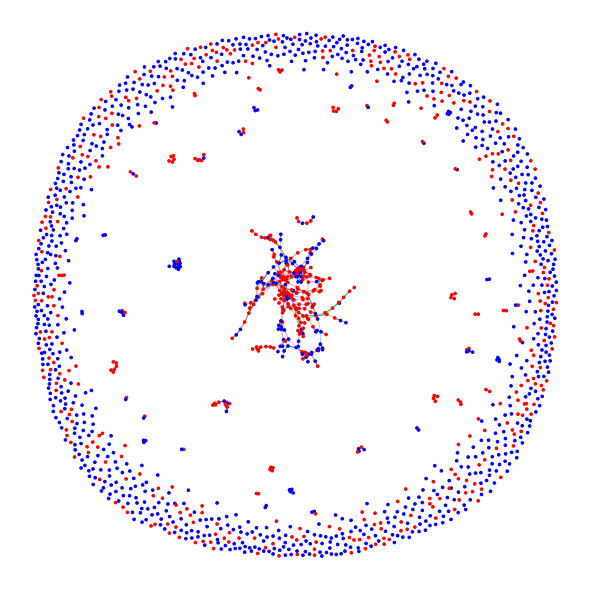

In [108]:
plt.figure(figsize=(8,8))
nx.draw(Gr, node_color=color_map, node_size=7, edge_color=edge_colors)
plt.show()

In [109]:
# Number of elements in bigger components
[len(c) for c in sorted(nx.connected_components(Gr), key=len, reverse=True)][:20]

[263, 14, 12, 8, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3]

In [110]:
print('Nº of nodes:', len(Gr.nodes()))
print('Nº of edges:', len(Gr.edges()))
#len(Gr.nodes())

Nº of nodes: 1645
Nº of edges: 665


In [111]:
# Group Influence in building the network
BY2_groups = dict.fromkeys(unique_group, 0)
for i in Gr.edges():
    BY2_groups[Gr.edges()[i]['group']] = BY2_groups[Gr.edges()[i]['group']] + Gr.edges()[i]['weight_inv']
BY2_groups

{'H2': 84.0,
 'CH2': 122.0,
 'CO2': 35.0,
 'O': 85.0,
 'CHOH': 62.0,
 'NCH': 21.0,
 'O(-NH)': 19.0,
 'S': 5.0,
 'CONH': 14.0,
 'PO3H': 25.0,
 'NH3(-O)': 26.0,
 'SO3': 6.0,
 'CO': 49.0,
 'C2H2O': 42.0,
 'H2O': 70.0}

In [112]:
a = 0
for i in BY2_groups.values():
    a = a + i
a

665.0

Induce the subgraph of the formulas that appear in the sample from the graph of the full dataset

In [113]:
BY2 = yeast_df[yeast_df.iloc[:,4] != 0]

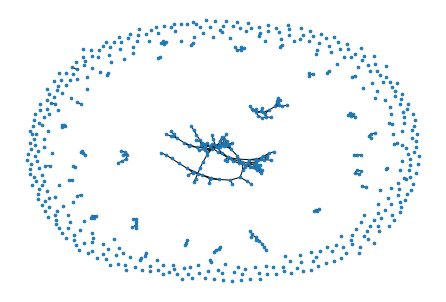

In [114]:
aaa = Gr.subgraph(BY2['Formula'])
nx.draw(aaa, node_size=7)
plt.show()

In [115]:
[len(c) for c in sorted(nx.connected_components(aaa), key=len, reverse=True)][:20]

[115, 22, 9, 8, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2]

### Old edge_assembler

In [116]:
def edge_assembler(formula_df, G):
    """Add all wanted possible edges to the formula network created and return a dictionary of the influence of each group
    in establishing the edges."""
    
    groups = ['H2','CH2','CO2','O','PH3','SH2','NH2','OH','SH','PH2','PO3H','NH3(-O)','SO3','CO']
    group_influence = dict.fromkeys(groups,0)
    
    for i in formula_df.index:
        node = formula_df.loc[i]
        
        #H2
        weight = edge_finder(G, formula_df, node, h=2)
        #print(weight)
        if weight != 0:
            group_influence['H2'] = group_influence['H2'] + (1/weight)

        #CH2
        weight = edge_finder(G, formula_df, node, c=1, h=2)
        if weight != 0:
            group_influence['CH2'] = group_influence['CH2'] + (1/weight)

        ######CO2
        weight = edge_finder(G, formula_df, node, c=1, o=2)
        if weight != 0:
            group_influence['CO2'] = group_influence['CO2'] + (1/weight)

        #O
        weight = edge_finder(G, formula_df, node, o=1)
        if weight != 0:
            group_influence['O'] = group_influence['O'] + (1/weight)

        ######PH3
        weight = edge_finder(G, formula_df, node, h=3, p=1)
        if weight != 0:
            group_influence['PH3'] = group_influence['PH3'] + (1/weight)

        ######SH2
        weight = edge_finder(G, formula_df, node, h=2, s=1)
        if weight != 0:
            group_influence['SH2'] = group_influence['SH2'] + (1/weight)

        #NH2
        weight = edge_finder(G, formula_df, node, h=2, n=1)
        if weight != 0:
            group_influence['NH2'] = group_influence['NH2'] + (1/weight)

        #OH
        weight = edge_finder(G, formula_df, node, h=1, o=1)
        if weight != 0:
            group_influence['OH'] = group_influence['OH'] + (1/weight)

        #SH
        weight = edge_finder(G, formula_df, node, h=1, s=1)
        if weight != 0:
            group_influence['SH'] = group_influence['SH'] + (1/weight)

        #PH2
        weight = edge_finder(G, formula_df, node, h=2, p=1)
        if weight != 0:
            group_influence['PH2'] = group_influence['PH2'] + (1/weight)
    
        #PO3(H)
        weight = edge_finder(G, formula_df, node, h=1, o=3, p=1)
        if weight != 0:
            group_influence['PO3H'] = group_influence['PO3H'] + (1/weight)

        #NH3-O
        weight = edge_finder(G, formula_df, node, h=3, o=-1, n=1)
        if weight != 0:
            group_influence['NH3(-O)'] = group_influence['NH3(-O)'] + (1/weight)

        #SO3
        weight = edge_finder(G, formula_df, node, h=0, o=3, s=1)
        if weight != 0:
            group_influence['SO3'] = group_influence['SO3'] + (1/weight)

        #CO
        weight = edge_finder(G, formula_df, node, c=1, o=1)
        if weight != 0:
            group_influence['CO'] = group_influence['CO'] + (1/weight)
                
    return group_influence